# Анализ пользовательского поведения

**Цель исследования**   

Анализ поведения пользователей в игре "Космические братья", а так же взаимосвязи поведения с источниками привлечения пользователей для последующих планирования и оптимизации рекламной кампании.

**Ход исследования**   
1. Обзор данных
1. Предобработка данных
1. Дополнительные вычисления
1. Портреты пользователей
1. Проверка гипотез 
1. Выводы
1. Создание дашбордов
1. Презентация результатов

## Материалы

**[Презентация](https://disk.yandex.ru/i/QKC10xkoieum_w)**

## Обзор данных

### Описание данных 

Подгружаем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth

Загружаем данные в датафреймы.

In [2]:
try: 
    ad_costs = pd.read_csv('https://raw.githubusercontent.com/Rikka-irk/Data-Analysis/main/Game%20project/ad_costs.csv')
    game_actions = pd.read_csv('https://raw.githubusercontent.com/Rikka-irk/Data-Analysis/main/Game%20project/game_actions.csv')
    user_source = pd.read_csv('https://raw.githubusercontent.com/Rikka-irk/Data-Analysis/main/Game%20project/user_source.csv')
    
except: 
    print('File reading error. Check the URLs')

**Затраты на рекламу**

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

In [3]:
ad_costs.sample(10).sort_values('day')

,source,day,cost
7,instagram_new_adverts,2020-05-03,943.204717
14,yandex_direct,2020-05-03,969.139394
21,youtube_channel_reklama,2020-05-03,454.224943
0,facebook_ads,2020-05-03,935.882786
15,yandex_direct,2020-05-04,554.651494
10,instagram_new_adverts,2020-05-06,173.071145
17,yandex_direct,2020-05-06,180.917099
4,facebook_ads,2020-05-07,111.766796
26,youtube_channel_reklama,2020-05-08,40.217907
12,instagram_new_adverts,2020-05-08,71.578739


In [4]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


**Действия пользователей в игре**

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    - `building` — объект построен,
    - `finished_stage_1` — первый уровень завершён,
    - `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    - `assembly_shop` — сборочный цех,
    - `spaceport` — космопорт,
    - `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

In [5]:
game_actions.sample(10).sort_values('event_datetime')

,event_datetime,event,building_type,user_id,project_type
32830,2020-05-07 12:43:16,building,assembly_shop,1ea65acf-834e-48e8-a06c-429d46a87ced,NaN
34227,2020-05-07 15:44:37,building,assembly_shop,dd5367af-73f3-45af-9401-1e5a23bc7600,NaN
67141,2020-05-10 06:36:20,building,assembly_shop,32749dd2-47f9-4cb7-ac89-cfa0113fc30d,NaN
88768,2020-05-12 06:37:32,building,spaceport,36d8a44d-e586-43fc-9565-a1ccf482da08,NaN
92025,2020-05-12 16:25:20,building,research_center,4f247cac-3c35-4b34-9720-73f7c8e8b026,NaN
108886,2020-05-14 23:43:10,building,spaceport,1c39b69d-c46d-4ba5-8412-948427dbbc2b,NaN
109927,2020-05-15 03:38:16,building,spaceport,043aedd8-6283-4404-9fc5-ec2d5bbc4018,NaN
118486,2020-05-16 16:07:14,finished_stage_1,NaN,4d48ff4a-e43a-4774-a741-7ef610f56624,NaN
133072,2020-05-22 17:53:26,finished_stage_1,NaN,f3e8f8a1-dea0-49ae-b0c4-5339bc007f0e,NaN
133993,2020-05-24 00:04:00,finished_stage_1,NaN,8b7dd408-5c1d-45cb-a1d3-6f07d159d792,NaN


In [6]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135639 entries, 0 to 135638
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135639 non-null  object
 1   event           135639 non-null  object
 2   building_type   127956 non-null  object
 3   user_id         135639 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


In [7]:
print('Типы событий')
display(game_actions.event.unique().tolist())

Типы событий


['building', 'finished_stage_1', 'project']

In [8]:
print('Типы построек')
display(game_actions.building_type.unique().tolist())

Типы построек


['assembly_shop', 'spaceport', nan, 'research_center']

In [9]:
print('Типы проектов')
display(game_actions.project_type.unique().tolist())

Типы проектов


[nan, 'satellite_orbital_assembly']

**Пользователи по источникам**

- `user_id` - идентификатор пользователя
- `source` - источник, с которого пришёл пользователь, установивший приложение

In [10]:
user_source.sample(10)

,user_id,source
8848,a67078ae-4fcb-4764-bf27-a917d9badbef,facebook_ads
8116,98fbedf2-f534-4b49-98c5-c60e59b221d8,instagram_new_adverts
5663,69aa7da8-b21f-44d4-82fb-9242aa642d26,instagram_new_adverts
9121,abb66f53-984c-4348-ad30-564b5808a063,facebook_ads
10675,c93c4cb1-c1fc-4ea5-beca-b452935c8b48,yandex_direct
13427,fd16a1a5-b3a2-43c8-beee-43631b53ba1d,yandex_direct
10581,c78ff5e8-cbc1-4e5a-b75a-9ebf7cc43c96,youtube_channel_reklama
8399,9e7bef5e-12e7-4011-ada8-7774e1655e70,instagram_new_adverts
9526,b3c2b809-26e2-4bd8-8a77-9cdd58afd3e5,yandex_direct
6207,738e5bc9-8a1a-4d65-993d-f2ff27a28f61,youtube_channel_reklama


In [11]:
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


Посмотрим за какой период данные.

In [12]:
print('События'+' \n'
      +'Дата начала периода: '+ game_actions.event_datetime.min()+' \n' 
      + 'Дата окончания периода: '+ game_actions.event_datetime.max())

События 
Дата начала периода: 2020-05-04 00:00:01 
Дата окончания периода: 2020-06-05 12:32:49


In [13]:
print('Затраты на рекламу'+' \n'
      +'Дата начала периода: '+ ad_costs.day.min()+' \n' 
      + 'Дата окончания периода: '+ ad_costs.day.max())

Затраты на рекламу 
Дата начала периода: 2020-05-03 
Дата окончания периода: 2020-05-09


In [14]:
print('Источники')
display(user_source.source.unique().tolist())

Источники


['facebook_ads',
 'yandex_direct',
 'youtube_channel_reklama',
 'instagram_new_adverts']

### Вывод

* В таблице `game_actions` присутствует много пропусков. На первый взгляд это может быть обусловлено механикой игры. Проверим это в дальнейшем.
* Предварительно можно утверждать, что данных достаточно для анализа и проверки гипотез.   
* Допольнительно стоит создать датафрейм со сводной информацией о пользователеях, их активности и стилю игры.
* Период проведения рекламной кампании: 03 - 09 Мая 2020г.
* Период первых игровый сессий: 04 - 10 Мая 2020г.
* Период игровой активности пользователей: 04 Мая - 05 Июня 2020г.
* Источники привлечения пользователей: 
    * Facebook ads 
    * Yandex Direct
    * YouTube Channel
    * Instagram Adverts.
    

<div class="alert alert-info"> <b>Комментарии студентки:</b> Добавила комментарий про пропуски</div>

<div class="alert alert-warning">
    <p><b>Комментарий тимлида: </b></p>
    
> Данные полные, структурированные.  
    
А что по поводу пропусков? В одном из датасетов есть пропуск практически в каждой строке. 
</div>

<div class="alert alert-success">
    <p><b>Комментарий тимлида v2: </b>👍</p>
</div>


## Предобработка данных

### Обработка пропусков

Проверим количество пустых значений в таблице `game_actions`.  
Так как в таблице содержатся записи о разных событиях с разным набором параметров, выведем отдельно события по типам.

In [15]:
game_actions.query('event == "building" ').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127956 entries, 0 to 135636
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  127956 non-null  object
 1   event           127956 non-null  object
 2   building_type   127956 non-null  object
 3   user_id         127956 non-null  object
 4   project_type    0 non-null       object
dtypes: object(5)
memory usage: 5.9+ MB


In [16]:
game_actions.query('event == "finished_stage_1" ').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5817 entries, 6659 to 135638
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   event_datetime  5817 non-null   object
 1   event           5817 non-null   object
 2   building_type   0 non-null      object
 3   user_id         5817 non-null   object
 4   project_type    0 non-null      object
dtypes: object(5)
memory usage: 272.7+ KB


In [17]:
game_actions.query('event == "project" ').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1866 entries, 47121 to 135629
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   event_datetime  1866 non-null   object
 1   event           1866 non-null   object
 2   building_type   0 non-null      object
 3   user_id         1866 non-null   object
 4   project_type    1866 non-null   object
dtypes: object(5)
memory usage: 87.5+ KB


Количество событий по типам соответствует описанию данных.


<div class="alert alert-success">
    <p><b>Комментарий тимлида: </b></p>
    
Верно, важно было сказать, что пропуски обусловлены механикой сбора данных и не являются ошибками.
</div> 


### Изменение типов данных

Проверим типы данных таблицы `game_actions`

In [18]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135639 entries, 0 to 135638
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135639 non-null  object
 1   event           135639 non-null  object
 2   building_type   127956 non-null  object
 3   user_id         135639 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


Приведем данные с датами к соответствующему типу

In [19]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
print(game_actions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135639 entries, 0 to 135638
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   127956 non-null  object        
 3   user_id         135639 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB
None


То же самое проделаем с датами в таблице `ad_costs`

In [20]:
ad_costs['day'] = pd.to_datetime(ad_costs['day'])
print(ad_costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes
None


### Проверка данных на аномалии

Посмотрим персентили стоимости привлечения пользователей на наличие выбросов.

In [21]:
ad_costs.describe(percentiles= [.10,.25,.50,.75,.85,.90,.95,.99])

,cost
count,28.000000
mean,271.556321
std,286.867650
min,23.314669
10%,42.011025
25%,66.747365
50%,160.056443
75%,349.034473
85%,546.083028
90%,669.020882


Проверим, совпадают ли id пользователей в таблицах `game_actions` и `user_source`

In [22]:
game_actions['user_id'].isin(user_source['user_id']).value_counts()

True    135639
Name: user_id, dtype: int64

Аномалий в даных не обнаружено.

<div class="alert alert-info"> <b>Комментарии студентки:</b> Добавила комментарий </div>

<div style="background:#d4d6fa; color:#000; padding:10px; margin-top:10px">
    <p><big><b> Итоговый Комментарий тимлида: </b></big></p> 
    
А какой вывод по наличию аномалий? Стоит сообщить, что с их нет
</div>

### Обработка дубликатов

Посмотрим количество дубликатов

In [23]:
game_actions.duplicated().value_counts()

False    135639
dtype: int64

Найдем эту зудблированную запись

In [24]:
dup_id = game_actions.duplicated().sort_values().tail(1).index
display(dup_id)

Int64Index([135638], dtype='int64')

In [25]:
game_actions.iloc[dup_id]

,event_datetime,event,building_type,user_id,project_type
135638,2020-06-05 12:32:49,finished_stage_1,NaN,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN


In [26]:
dup_user_id = game_actions.iloc[dup_id]['user_id']
dup_user_id = dup_user_id.values
display(dup_user_id)

array(['f21d179f-1c4b-437e-b9c6-ab1976907195'], dtype=object)

In [27]:
#game_actions.loc[game_actions['user_id']==dup_user_id]#['user_id']
game_actions.query('user_id == @dup_user_id[0]') #.sort_values('event_datetime')

,event_datetime,event,building_type,user_id,project_type
18429,2020-05-06 02:56:25,building,assembly_shop,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
25837,2020-05-06 21:04:09,building,assembly_shop,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
38835,2020-05-08 01:42:00,building,assembly_shop,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
63845,2020-05-10 01:05:51,building,assembly_shop,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
103682,2020-05-14 05:12:46,building,spaceport,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
117515,2020-05-16 11:31:15,building,spaceport,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
125141,2020-05-18 09:22:14,building,spaceport,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
134209,2020-05-24 10:30:05,building,spaceport,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
135475,2020-05-29 12:45:32,building,spaceport,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
135505,2020-05-30 01:25:45,building,spaceport,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN


Удалим дубликат и проверим результат

<div class="alert alert-success">
    <p><b>Комментарий тимлида: </b></p>
    
Согласен, дубликат нам не нужен
</div> 

In [28]:
game_actions = game_actions.drop_duplicates()

In [29]:
game_actions.duplicated().value_counts()

False    135639
dtype: int64

Проверим наличие дубликатов в остальных таблицах.   
А так же отдельно проверим наличие дублирований `user_id` в таблице с источниками

In [30]:
ad_costs.duplicated().value_counts()

False    28
dtype: int64

In [31]:
user_source.duplicated().value_counts()

False    13576
dtype: int64

In [32]:
user_source['user_id'].duplicated().value_counts()

False    13576
Name: user_id, dtype: int64

### Формирование дополнительных датафреймов 

Скопируем таблицу `source` в новую таблицу `users`

In [33]:
users = user_source.copy().set_index('user_id')
display(users.head(10))

,source
user_id,
0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads
003b80c6-4164-4157-bb2a-03d0181d39c4,yandex_direct
003ee7e8-6356-4286-a715-62f22a18d2a1,instagram_new_adverts
004074f8-251a-4776-922c-8348dca1a2f6,facebook_ads
00440efd-aa50-4b4b-aae8-ffcd1782729d,facebook_ads


### Вывод

В рамках предобработки данных была проведена следующая работа:
- проверено наличие пропусков
- удалены дубликаты
- данные приведены к соответствующим типам
- сформирован дополнительный датафрейм со списком пользователей для дальнейших вычислений


## Дополнительные вычисления

Пополнение таблицы `users` следующими данными по каждому пользователю:

### Общее время в днях, проведенное в игре

In [34]:
time_spent = game_actions.groupby('user_id')['event_datetime'].agg([min, max] )
time_spent['time'] = (time_spent['max'] - time_spent['min']).dt.days
users = users.join(time_spent['time'], how = 'left')


In [35]:
display(users.sort_values('time').sample(15))

,source,time
user_id,,
0a6df125-87d6-49cb-bb52-28fa4067b643,yandex_direct,12
a44f0ceb-6164-44fc-8e38-d59b925ff417,youtube_channel_reklama,13
abed2479-f18c-4ae4-ac01-40e411da3c7e,instagram_new_adverts,14
c8e18e21-22b5-4304-9bce-492872a12a1f,youtube_channel_reklama,11
b3bc0ec8-eb86-4fe1-8925-99d95d1179e7,facebook_ads,12
74161718-eb8e-433f-8d3b-b7d08be9b419,facebook_ads,9
7843ae35-9724-4995-a2a7-6d45d2a77a4a,instagram_new_adverts,9
439544d5-d223-4cac-8f93-fa2bad764cc1,facebook_ads,12
0b367fb1-3475-4ccc-9857-839ea7b6c63f,instagram_new_adverts,8


### Время до перехода на новый уровень

Найдем в таблице событий первую запись и запись о завершении уровня для кажого пользователя и посчитаем между ними разницу в днях. Это будет время до перехода на новый уровень, для пользователей, которые завершили первый.

In [36]:
#finished_stage_1
time_spent = game_actions.groupby('user_id')['event_datetime'].agg([min] )
time_spent['finish'] = game_actions\
                        .query("event == 'finished_stage_1'")\
                        .groupby('user_id')['event_datetime']\
                        .agg([min] )

time_spent['fin_level_time'] = (time_spent['finish'] - time_spent['min']).dt.days
display(time_spent.sample(10))

,min,finish,fin_level_time
user_id,,,
cba8ec72-fb6c-45cd-88fe-c34983d6513d,2020-05-09 13:55:42,NaT,NaN
51009fcc-10b1-413d-86ae-06e563fbccd2,2020-05-05 21:14:35,NaT,NaN
b05165e3-d79f-41fb-9be2-c41c8c871269,2020-05-04 12:58:16,NaT,NaN
d15bd276-2f7b-4427-a082-0d21da92632e,2020-05-05 01:54:24,NaT,NaN
edcbcb68-2d18-480e-9b9f-9a512b23fbf7,2020-05-05 12:49:25,NaT,NaN
9a40eb9f-ced8-46e8-8fce-b20fa86eb2d3,2020-05-06 06:15:26,2020-05-16 14:16:09,10.0
ab09a4ab-4d28-4dda-81c4-b93d3ea3e480,2020-05-04 00:03:03,NaT,NaN
1b583b45-7400-4456-b6c3-8e8842f3d5b0,2020-05-09 06:53:12,2020-05-13 02:33:28,3.0
5f526817-a7cf-43f6-a338-27c22e5239f0,2020-05-04 10:46:07,2020-05-18 23:21:47,14.0


Добавим всем пользователям запись о последнем событии, чтобы найти пользователей, которые уровень не прошли.

In [37]:
time_spent['last_event'] = game_actions.groupby('user_id')['event_datetime'].agg(max )

Объеденим полученные данные с таблицой `users`

In [38]:
users = users.join(time_spent, how = 'left')
display(users.sample(10))

,source,time,min,finish,fin_level_time,last_event
user_id,,,,,,
e7c3770a-4dcb-407a-833f-4b254c8201df,youtube_channel_reklama,15,2020-05-04 16:45:43,2020-05-20 03:54:22,15.0,2020-05-20 03:54:22
c43df5ef-2f5a-4f37-9e81-0c6b3353e807,facebook_ads,5,2020-05-05 01:06:34,NaT,NaN,2020-05-10 23:15:19
28e4a478-b142-4897-b288-f625797a0936,youtube_channel_reklama,8,2020-05-05 05:09:25,2020-05-14 04:19:32,8.0,2020-05-14 04:19:32
5c59e3a3-b235-46a5-990d-eb4c3b7a6300,instagram_new_adverts,5,2020-05-04 16:00:56,NaT,NaN,2020-05-10 06:26:33
c51796d7-1d07-4e62-9b6b-9df125042f7a,yandex_direct,11,2020-05-08 14:22:06,NaT,NaN,2020-05-19 14:35:54
726fa8e2-6f4a-433f-b6e2-437835360287,yandex_direct,19,2020-05-09 13:18:20,NaT,NaN,2020-05-29 12:28:59
3df4551d-191f-4ec4-a112-2c7c1511a9a9,yandex_direct,22,2020-05-04 01:35:02,2020-05-26 04:56:11,22.0,2020-05-26 04:56:11
0718d017-6254-44b6-81c8-a6354f09ad47,instagram_new_adverts,21,2020-05-08 02:11:57,NaT,NaN,2020-05-29 19:39:17
ccbfffa8-2efe-49ef-a176-b5c826805074,yandex_direct,5,2020-05-06 21:56:58,NaT,NaN,2020-05-12 14:50:03



### Количество построек до перехода на новый уровень

Посчитаем количество построек у каждого игрока по событиям о постройке, и добавим эту информацию в таблицу `users`.

In [39]:
building = game_actions.query("event == 'building'").groupby('user_id')['event'].agg('count')


In [40]:
users['buildings'] = building
display(users.sample(10))

,source,time,min,finish,fin_level_time,last_event,buildings
user_id,,,,,,,
64c1ff07-ca0b-44c0-839c-4c5ed5085ae3,instagram_new_adverts,2,2020-05-07 09:49:08,NaT,NaN,2020-05-09 20:35:53,5
3b6e1b98-1204-4fd7-9711-e433f3e17508,yandex_direct,15,2020-05-04 01:05:55,2020-05-19 09:54:39,15.0,2020-05-19 09:54:39,13
0296c1f8-aed6-4538-b737-418821666794,yandex_direct,14,2020-05-06 01:20:23,NaT,NaN,2020-05-20 06:28:40,10
429c4bd0-6380-47cc-97cc-b60400119a5a,yandex_direct,9,2020-05-07 03:23:25,NaT,NaN,2020-05-16 18:06:10,9
a053ce24-e72b-4147-bd39-15f22169a6e1,facebook_ads,11,2020-05-04 13:21:06,NaT,NaN,2020-05-16 10:07:12,9
979e3bb0-3141-4b35-8cb5-84c354ea5df8,yandex_direct,7,2020-05-09 21:00:05,NaT,NaN,2020-05-17 14:25:01,4
84fe1224-b1d0-4294-b9c0-c66f1cd08686,youtube_channel_reklama,10,2020-05-04 02:57:50,NaT,NaN,2020-05-14 11:36:24,9
cc07687d-6cb5-4162-b5b7-cd2ec9251e10,instagram_new_adverts,8,2020-05-08 00:40:49,NaT,NaN,2020-05-16 09:19:48,10
444dba85-35e8-40d0-8d63-da8c44f119fd,yandex_direct,16,2020-05-05 11:40:58,2020-05-22 04:02:11,16.0,2020-05-22 04:02:11,14


### Тип завершения первого уровня

Пользователям, завершившим проект, поставим флаг `project`

In [41]:
users['project'] = game_actions\
                    .query("project_type == 'satellite_orbital_assembly'")\
                    .groupby('user_id')['event']\
                    .agg('count').sort_values()
display(users.sample(10))

,source,time,min,finish,fin_level_time,last_event,buildings,project
user_id,,,,,,,,
7ec9494b-5a75-497e-8ef9-378e046617ee,yandex_direct,10,2020-05-04 03:19:05,2020-05-15 02:43:19,10.0,2020-05-15 02:43:19,12,NaN
227a12d0-e90e-43dd-ba58-945fd403a756,facebook_ads,8,2020-05-04 03:55:23,NaT,NaN,2020-05-12 11:33:24,3,NaN
a2e54343-2c6e-4e76-88c3-f7e7a0216414,facebook_ads,11,2020-05-04 22:59:44,2020-05-16 03:48:02,11.0,2020-05-16 03:48:02,12,NaN
42617c25-de0f-4fbc-8dc1-f34f259eedaa,instagram_new_adverts,8,2020-05-04 01:02:00,NaT,NaN,2020-05-12 12:06:50,5,NaN
7b2d2752-58fc-4cf3-bbbf-7968131869da,yandex_direct,22,2020-05-05 03:24:30,2020-05-27 05:18:52,22.0,2020-05-27 05:18:52,9,NaN
dc898510-30dd-4ecd-bca7-6f46c1006638,youtube_channel_reklama,7,2020-05-06 21:32:52,NaT,NaN,2020-05-14 20:07:44,10,NaN
eb4a7f96-053a-4395-9312-6237f3ec449a,youtube_channel_reklama,15,2020-05-04 08:23:55,2020-05-19 20:55:09,15.0,2020-05-19 20:55:09,10,NaN
71e0b5f8-552a-4766-9f99-a97478cb04d7,facebook_ads,8,2020-05-04 16:52:17,NaT,NaN,2020-05-13 07:12:43,11,NaN
518a502f-eae9-428e-932a-53e298d56799,facebook_ads,4,2020-05-05 00:18:59,NaT,NaN,2020-05-09 20:43:56,5,NaN


Проставим для всех игроков указатель способа завершения уровня.

In [42]:
# если fin_level_time нан - incompleted
# если fin_level_time не нан и  project_type Труе - project
# если fin_level_time не нан и  project_type Фалсе - fight

def level_fin (x):
    if pd.isna(x['fin_level_time']):
        return 'incomplete'
    else:
        if x['project'] == 1:
            return 'project'
        else: 
            return 'fight'

In [43]:
users['fin_type'] = users.apply(level_fin, axis=1)
display(users.sample(10))

,source,time,min,finish,fin_level_time,last_event,buildings,project,fin_type
user_id,,,,,,,,,
7a1f037d-930f-4763-ba15-e978107433f2,yandex_direct,7,2020-05-08 02:05:20,NaT,NaN,2020-05-15 10:46:08,6,NaN,incomplete
d752d72f-3d4a-4499-82cc-65ed94ded043,yandex_direct,5,2020-05-07 22:09:57,NaT,NaN,2020-05-13 00:35:10,3,NaN,incomplete
f6e68b19-9917-4ca0-bc46-4c3f58bc625c,yandex_direct,10,2020-05-04 05:49:03,2020-05-14 22:04:08,10.0,2020-05-14 22:04:08,11,NaN,fight
36e7ac24-4971-4396-9e95-30351a988710,youtube_channel_reklama,14,2020-05-05 03:48:12,NaT,NaN,2020-05-19 06:00:30,13,NaN,incomplete
67608d2f-837c-4c2f-838d-2351473b70ae,youtube_channel_reklama,12,2020-05-06 01:42:24,2020-05-18 14:43:07,12.0,2020-05-18 14:43:07,10,NaN,fight
6c562c9c-26c2-4c12-805e-77fa504adb21,facebook_ads,12,2020-05-04 06:05:51,2020-05-17 02:15:06,12.0,2020-05-17 02:15:06,15,1.0,project
8439aab6-7343-431e-8bab-75b3c4b893b3,facebook_ads,6,2020-05-07 02:15:15,NaT,NaN,2020-05-13 23:17:36,2,NaN,incomplete
443329e8-67dc-45a8-baf3-28da2a5a42e6,youtube_channel_reklama,2,2020-05-05 12:21:02,NaT,NaN,2020-05-08 06:40:36,2,NaN,incomplete
6647bcf2-f880-475f-a18a-fa2f2bb7077f,youtube_channel_reklama,10,2020-05-06 03:05:06,2020-05-16 15:09:48,10.0,2020-05-16 15:09:48,11,NaN,fight


Приведем таблицу пользователей в порядок.

In [44]:
users = users[['source','min','last_event','time','buildings','fin_type']]
users = users.rename(columns = {'time':'days_spent', 'min':'first_event'})

In [45]:
users['first_event'] = users.first_event.dt.date
users['last_event'] = users.last_event.dt.date
display(users.sample(10))

,source,first_event,last_event,days_spent,buildings,fin_type
user_id,,,,,,
dbb6fea3-3d89-4353-9f9b-59fbfd318747,instagram_new_adverts,2020-05-10,2020-05-18,7,6,incomplete
1d59a266-030a-427f-8c3e-81597c653f07,facebook_ads,2020-05-04,2020-05-13,9,17,incomplete
a5918160-5b14-448c-910f-6a35a3162295,yandex_direct,2020-05-04,2020-05-19,15,8,fight
a807905c-85b1-4045-97e8-41ece340a8cb,facebook_ads,2020-05-09,2020-05-25,16,12,incomplete
a7e64f19-3a60-4553-ad20-3d4cd8c926b8,yandex_direct,2020-05-06,2020-05-12,6,5,incomplete
b0736336-9e3a-45ac-bb32-cba0fd8b314c,yandex_direct,2020-05-04,2020-05-17,13,17,incomplete
bf4a931c-eed0-4cde-b0c3-5492958c596f,yandex_direct,2020-05-04,2020-05-12,7,7,incomplete
e2438e2b-6bc2-4ceb-8491-e1c024fb1380,youtube_channel_reklama,2020-05-04,2020-05-24,20,9,fight
2fe039d5-3630-48c5-ada3-3c4a0e034119,facebook_ads,2020-05-05,2020-05-12,7,6,incomplete


### Вывод

В ходе работы была создана таблица с игроками, и заполнена следующей информацией:
* В качестве индексов в таблице используются `id` пользователей 
* `source` – рекламный источник
* `first_event last_event` – даты первого и последнего события игрока
* `days_spent` – дней в игре
* `buildings` – зданий построено
* `fin_type` – способ прохождения уровня: `project` – построен проект, `fight` – убит первый враг, `incomplete` – уровень не завершен

## Портреты пользователей

In [46]:
print('Уникальных пользователей: ',users.shape[0])

Уникальных пользователей:  13576


Проанализируем и разобьем на подгруппы пользователей, в зависимости от их стиля игры и от того, через какой источник они пришли в игру.

### По источникам

Зависимость стиля игры от источника

#### Facebook

In [47]:
fb_users = users.query("source == 'facebook_ads'")

In [48]:
fb_users.sample(10)

,source,first_event,last_event,days_spent,buildings,fin_type
user_id,,,,,,
a270c244-b54d-496c-a706-c4da315ded3a,facebook_ads,2020-05-04,2020-05-17,13,11,fight
71c98190-c2e0-4ac3-9252-cca6feda7675,facebook_ads,2020-05-10,2020-05-21,10,5,incomplete
cedac848-f1f4-431d-9a53-5ccd725d5cdc,facebook_ads,2020-05-05,2020-05-16,10,12,incomplete
545d5caa-999d-4f5f-a192-dee4d66d2f9d,facebook_ads,2020-05-07,2020-05-07,0,1,incomplete
dfe2c2e8-52d8-4ca6-a3b1-81bd997e46ca,facebook_ads,2020-05-07,2020-05-21,14,15,project
de1e873a-ea74-4bc4-8d4e-caf2d1e38fee,facebook_ads,2020-05-09,2020-05-17,7,4,incomplete
7a7ebb9e-3ab0-47ad-919b-9b09c53b5145,facebook_ads,2020-05-04,2020-05-12,8,4,incomplete
d0584c51-09d8-4c24-bf66-cdc112c95210,facebook_ads,2020-05-06,2020-05-16,10,10,fight
d0f9944c-61fe-4270-a861-919fbe778015,facebook_ads,2020-05-05,2020-05-13,8,12,project


Распределение пользователей по проведенным в игре дням

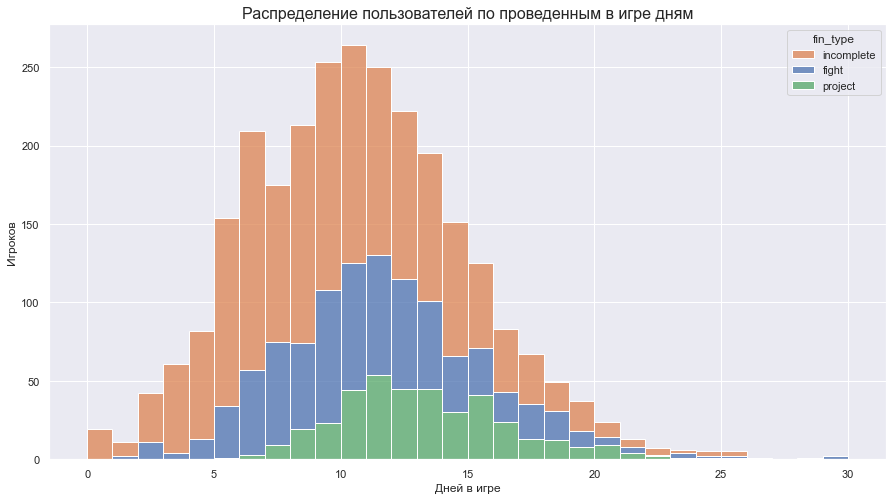

In [49]:
sns.set(rc={'figure.figsize':(15,8)})
palette ={ "fight": "C0","incomplete": "C1", "project": "C2"}
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(1,1,1)
sns.histplot(data=fb_users, ax=ax, stat="count", multiple="stack",
             x="days_spent", kde=False,
             palette=palette, hue="fin_type",
             element="bars", legend=True, bins=30)
plt.title('Распределение пользователей по проведенным в игре дням', fontsize=16)
plt.xlabel('Дней в игре')
plt.ylabel('Игроков');

Распределение по количеству простроенных объектов

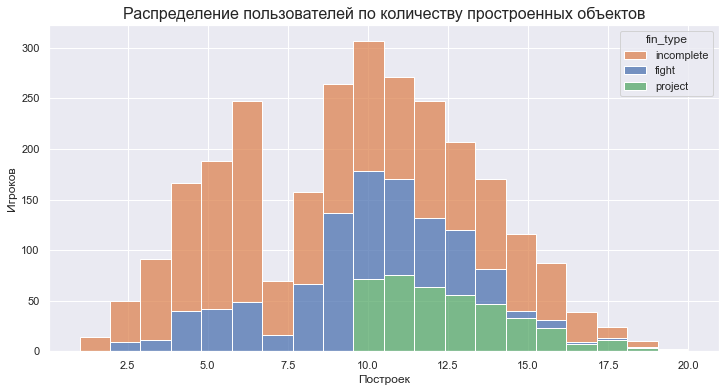

In [50]:
f = plt.figure(figsize=(12,6))
ax = f.add_subplot(1,1,1)
palette ={ "fight": "C0","incomplete": "C1", "project": "C2"}
sns.histplot(data=fb_users, ax=ax, stat="count", multiple="stack",
             x="buildings", kde=False,
             palette=palette, hue="fin_type",
             element="bars", legend=True, bins=20)
plt.title('Распределение пользователей по количеству простроенных объектов', fontsize=16)
plt.xlabel('Построек')
plt.ylabel('Игроков');

Диаграмма рассеяния, показывающая зависимость количества построенных зданий от количества дней, проведенных в игре и от типа завершения уровня.

<div style="background:#d4d6fa; color:#000; padding:10px; margin-top:10px">
    <p><b> Комментарий тимлида: </b></p>
    
Я вижу довольно подозрительную просадку на 7-8 зданиях. Возможно, там есть какая-то особенность механики (и не факт, что особенность положительная). Стоит сообщить отделу геймдизайнерам о ней, пусть они разбираться в том, что же там происходит на самом делее.
</div>

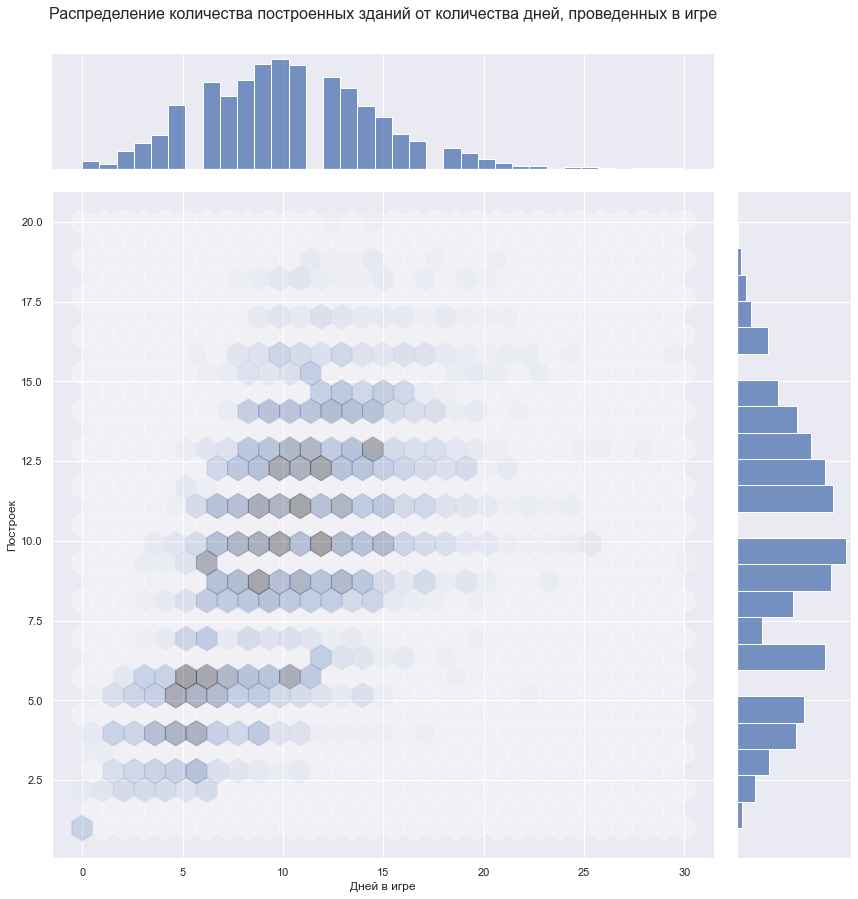

In [51]:
#fb_users.plot.scatter(x='days_spent', y='buildings')
sns.set(rc={'figure.figsize':(12,12)})
palette ={ "fight": "C0","incomplete": "C1", "project": "C2"}

sns.jointplot(data=fb_users, 
                x="days_spent", 
                y="buildings", 
                #hue="fin_type",
                kind='hex',
                palette=palette, 
                height  = 12, alpha=0.3
              )
plt.title('Распределение количества построенных зданий от количества дней, проведенных в игре',  y=1.25,fontsize=16)
plt.xlabel('Дней в игре')
plt.ylabel('Построек');

Круговая диаграмма с разбивкой по типам завершения уровня

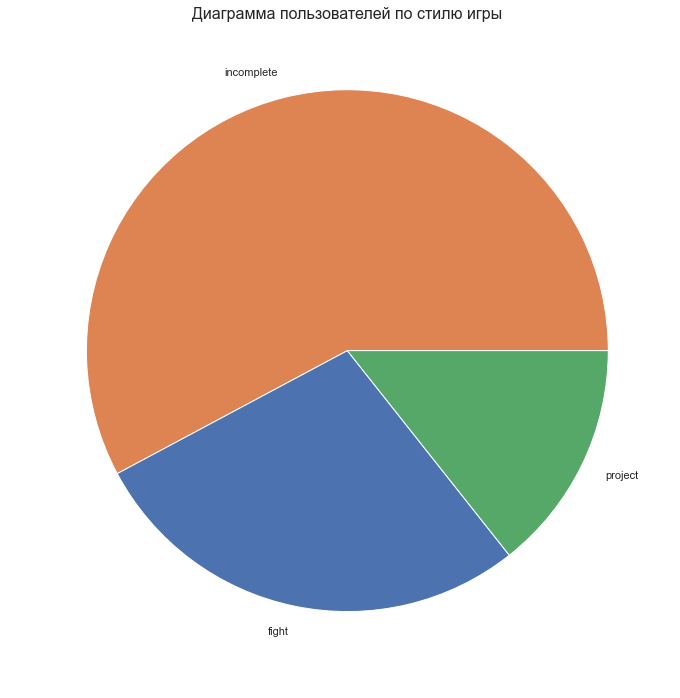

In [52]:
fb_users.groupby('fin_type')['source'].count()\
                                      .sort_values(ascending=False)\
                                      .plot.pie(colors = ['C1','C0','C2'])
plt.title('Диаграмма пользователей по стилю игры', fontsize=16)
plt.xlabel(' ')
plt.ylabel(' ');

Посмотрим, сколько времени проводят в игре пользователи, не завершившие уровень

<div style="background:#d4d6fa; color:#000; padding:10px; margin-top:10px">
    <p><b> Комментарий тимлида: </b></p>
    
Как правило, не достаточно сказать на что мы смотрим, или что за диаграмма показано. Основной интерес составляют именно выводы из графика, а не сам факт создания графика. 
</div>

In [53]:
fb_users.query("fin_type =='incomplete'").describe()

,days_spent,buildings
count,1576.000000,1576.000000
mean,9.402284,8.901015
std,4.360352,4.181331
min,0.000000,1.000000
25%,6.000000,5.000000
50%,9.000000,9.000000
75%,12.000000,12.000000
max,25.000000,20.000000


Количество дней в игре в зависимости от типа завершения уровня

In [54]:
fb_users.groupby('fin_type')['days_spent'].describe()

,count,mean,std,min,25%,50%,75%,max
fin_type,,,,,,,,
fight,759.0,10.546772,4.090353,1.0,8.0,10.0,13.0,30.0
incomplete,1576.0,9.402284,4.360352,0.0,6.0,9.0,12.0,25.0
project,391.0,12.905371,3.528455,5.0,10.0,12.0,15.0,28.0


Количество построенных зданий в зависимости от типа завершения уровня

In [55]:
fb_users.groupby('fin_type')['buildings'].describe()

,count,mean,std,min,25%,50%,75%,max
fin_type,,,,,,,,
fight,759.0,9.429513,3.027573,2.0,8.0,10.0,11.0,19.0
incomplete,1576.0,8.901015,4.181331,1.0,5.0,9.0,12.0,20.0
project,391.0,12.649616,2.198483,10.0,11.0,12.0,14.0,20.0


#### Instagram

In [56]:
inst_users = users.query("source == 'instagram_new_adverts'")

In [57]:
inst_users.sample(10)

,source,first_event,last_event,days_spent,buildings,fin_type
user_id,,,,,,
1a58ec7a-b794-41f5-ac2b-1be51c0ab161,instagram_new_adverts,2020-05-04,2020-05-14,9,12,incomplete
240ab513-3470-4b30-9ca0-820d5b53cc67,instagram_new_adverts,2020-05-07,2020-05-13,5,3,fight
a9e16858-b61c-41fc-ad8b-ca7d12b125d4,instagram_new_adverts,2020-05-04,2020-05-11,7,8,incomplete
f88d56aa-6300-447a-9e7a-7d5c1dab9571,instagram_new_adverts,2020-05-08,2020-05-24,15,10,fight
bb65ef85-17bc-4c23-b806-58246d815f4f,instagram_new_adverts,2020-05-06,2020-05-16,10,6,incomplete
bdaa8ee5-24dc-4d51-8aff-5423be32924d,instagram_new_adverts,2020-05-04,2020-05-17,12,10,project
8feea86f-829a-4cec-912e-0d8faebb83fb,instagram_new_adverts,2020-05-04,2020-05-19,15,4,fight
dabdd45f-9e98-45c0-a7c0-c4d5b3dbfdac,instagram_new_adverts,2020-05-05,2020-05-18,12,12,fight
105cfe28-ba99-4ef4-a415-73a668611fd6,instagram_new_adverts,2020-05-05,2020-05-20,14,13,incomplete


Распределение пользователей по проведенным в игре дням

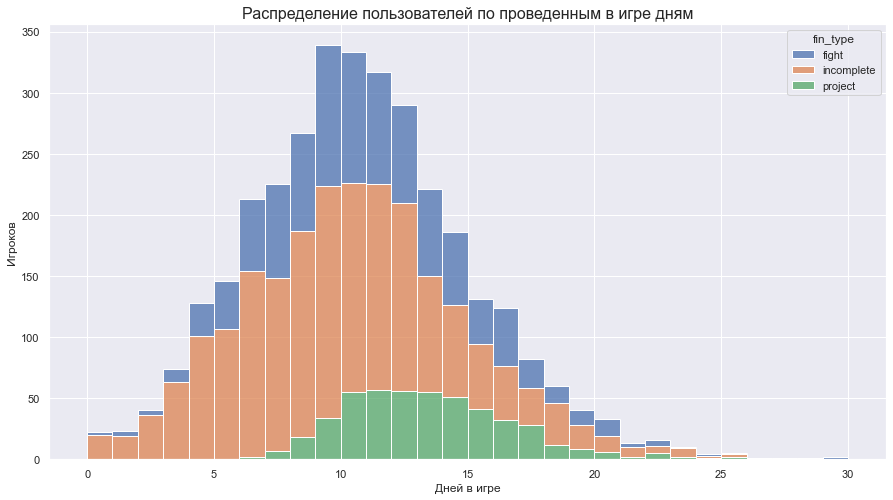

In [58]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(1,1,1)
palette ={"incomplete": "C1", "fight": "C0", "project": "C2"}
sns.histplot(data=inst_users, ax=ax, stat="count", multiple="stack",
             x="days_spent", kde=False,
             palette=palette, hue="fin_type",
             element="bars", legend=True, bins=30)

plt.title('Распределение пользователей по проведенным в игре дням', fontsize=16)
plt.xlabel('Дней в игре')
plt.ylabel('Игроков');

Распределение по количеству простроенных объектов

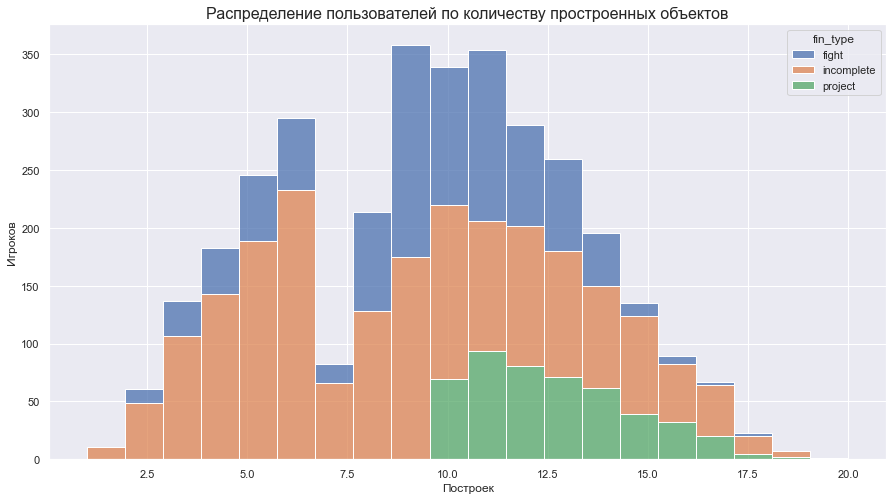

In [59]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(1,1,1)
sns.histplot(data=inst_users, ax=ax, stat="count", multiple="stack",
             x="buildings", kde=False,
             palette=palette, hue="fin_type",
             element="bars", legend=True, bins=20)
plt.title('Распределение пользователей по количеству простроенных объектов', fontsize=16)
plt.xlabel('Построек')
plt.ylabel('Игроков');

Диаграмма рассеяния, показывающая зависимость количества построенных зданий от количества дней, проведенных в игре и от типа завершения уровня.

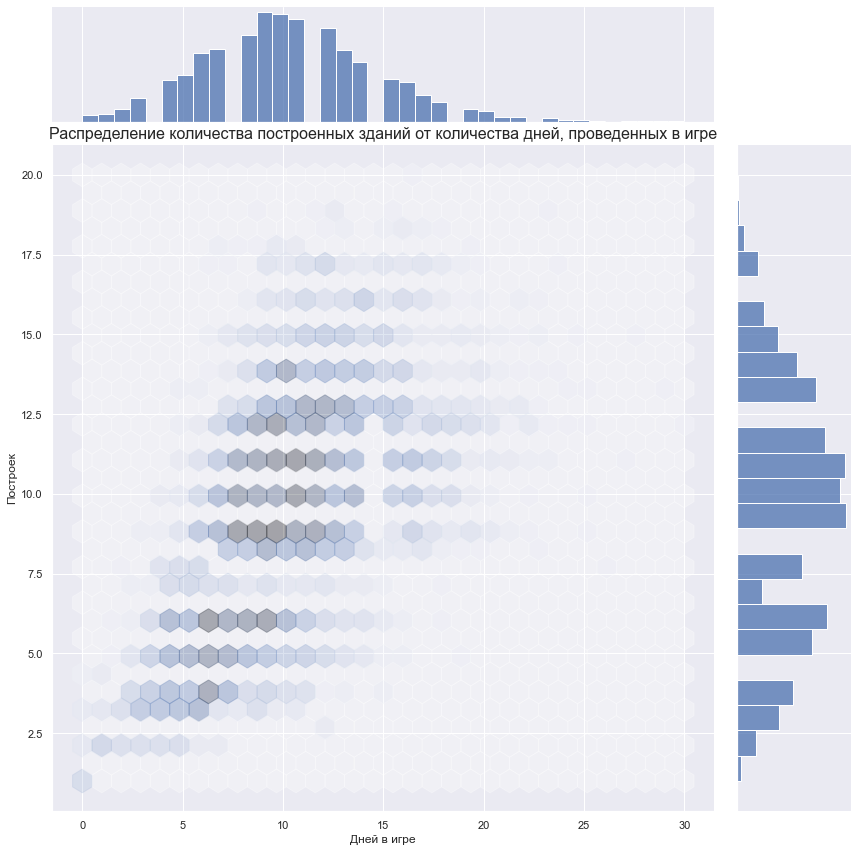

In [60]:
#fb_users.plot.scatter(x='days_spent', y='buildings')
sns.set(rc={'figure.figsize':(15,8)})
palette ={ "fight": "C0","incomplete": "C1", "project": "C2"}
sns.jointplot(data=inst_users, 
                x="days_spent", 
                y="buildings", 
                #hue="fin_type",
                kind='hex',
                palette=palette, 
                height  = 12, alpha=0.3
              )
plt.title('Распределение количества построенных зданий от количества дней, проведенных в игре', fontsize=16)
plt.xlabel('Дней в игре')
plt.ylabel('Построек');

Круговая диаграмма с разбивкой по типам завершения уровня

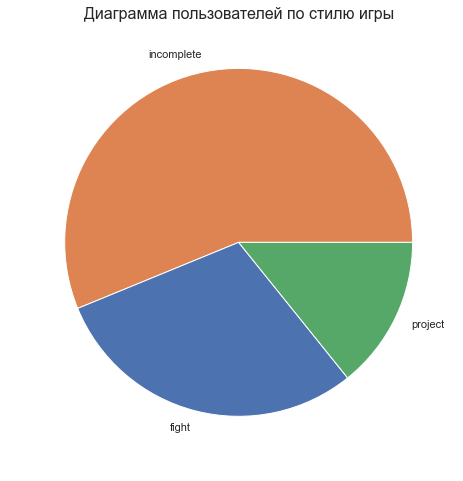

In [61]:
inst_users.groupby('fin_type')['source'].count()\
                                      .sort_values(ascending=False)\
                                      .plot.pie(colors = ['C1','C0','C2'])
plt.title('Диаграмма пользователей по стилю игры', fontsize=16)
plt.xlabel(' ')
plt.ylabel(' ');

Посмотрим, сколько времени проводят в игре пользователи, не завершившие уровень

In [62]:
inst_users.query("fin_type =='incomplete'").describe()

,days_spent,buildings
count,1881.000000,1881.000000
mean,9.418926,8.738437
std,4.351564,4.099125
min,0.000000,1.000000
25%,6.000000,5.000000
50%,9.000000,9.000000
75%,12.000000,12.000000
max,26.000000,19.000000


Количество дней в игре в зависимости от типа завершения уровня

In [63]:
inst_users.groupby('fin_type')['days_spent'].describe()

,count,mean,std,min,25%,50%,75%,max
fin_type,,,,,,,,
fight,990.0,10.622222,4.084139,0.0,8.0,10.0,13.0,30.0
incomplete,1881.0,9.418926,4.351564,0.0,6.0,9.0,12.0,26.0
project,476.0,13.039916,3.408423,6.0,11.0,13.0,15.0,28.0


Количество построенных зданий в зависимости от типа завершения уровня

In [64]:
inst_users.groupby('fin_type')['buildings'].describe()

,count,mean,std,min,25%,50%,75%,max
fin_type,,,,,,,,
fight,990.0,9.400000,3.054543,2.0,8.0,10.0,11.0,18.0
incomplete,1881.0,8.738437,4.099125,1.0,5.0,9.0,12.0,19.0
project,476.0,12.756303,2.113481,10.0,11.0,12.0,14.0,20.0


#### YouTube

In [65]:
yt_users = users.query("source == 'youtube_channel_reklama'")

In [66]:
yt_users.sample(10)

,source,first_event,last_event,days_spent,buildings,fin_type
user_id,,,,,,
0587fefd-2b92-4a30-afeb-4a0fb27763ef,youtube_channel_reklama,2020-05-04,2020-05-16,12,15,incomplete
5b457d0f-e5c3-4fa0-8083-ca608b25f225,youtube_channel_reklama,2020-05-06,2020-05-08,2,4,fight
608cf576-e43e-4db5-83c1-cb666e697a85,youtube_channel_reklama,2020-05-04,2020-05-12,8,9,fight
34832480-c8b1-4885-b17a-03164818ca3e,youtube_channel_reklama,2020-05-04,2020-05-22,17,18,incomplete
6bb111ba-92ad-4818-bd6b-364efb678979,youtube_channel_reklama,2020-05-07,2020-05-27,19,12,incomplete
72a9b124-b46e-41da-84a8-7dc360ca9889,youtube_channel_reklama,2020-05-04,2020-05-15,10,10,incomplete
550fdfa4-3712-4b96-82ff-10c366a4bba2,youtube_channel_reklama,2020-05-04,2020-05-13,9,8,incomplete
47b73b90-9234-4c72-9fab-e48e4954d593,youtube_channel_reklama,2020-05-08,2020-05-19,10,10,fight
693d0711-6a19-47fd-9b47-da0613c1d1d6,youtube_channel_reklama,2020-05-04,2020-05-13,9,9,fight


Распределение пользователей по проведенным в игре дням

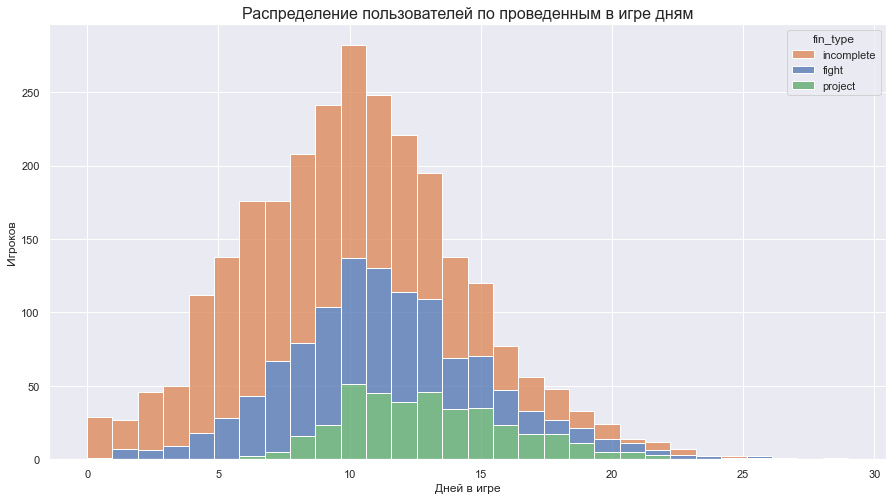

In [67]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(1,1,1)
sns.histplot(data=yt_users, ax=ax, stat="count", multiple="stack",
             x="days_spent", kde=False,
             palette=palette, hue="fin_type",
             element="bars", legend=True, bins=30)

plt.title('Распределение пользователей по проведенным в игре дням', fontsize=16)
plt.xlabel('Дней в игре')
plt.ylabel('Игроков');

Распределение по количеству простроенных объектов

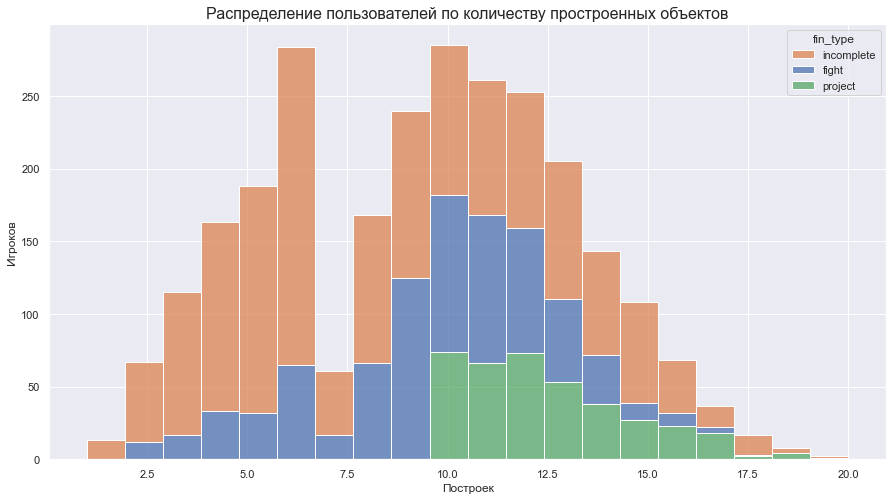

In [68]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(1,1,1)
sns.histplot(data=yt_users, ax=ax, stat="count", multiple="stack",
             x="buildings", kde=False,
             palette=palette, hue="fin_type",
             element="bars", legend=True, bins=20)
plt.title('Распределение пользователей по количеству простроенных объектов', fontsize=16)
plt.xlabel('Построек')
plt.ylabel('Игроков');

Диаграмма рассеяния, показывающая зависимость количества построенных зданий от количества дней, проведенных в игре и от типа завершения уровня.

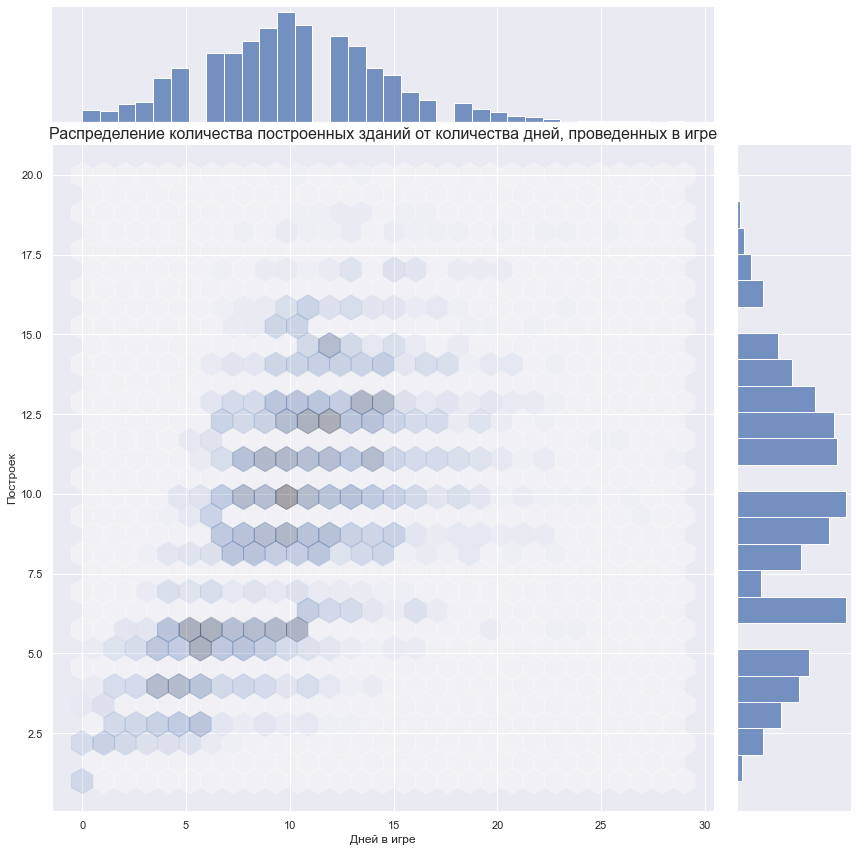

In [69]:
#fb_users.plot.scatter(x='days_spent', y='buildings')
sns.set(rc={'figure.figsize':(15,8)})
palette ={ "fight": "C0","incomplete": "C1", "project": "C2"}
sns.jointplot(data=yt_users, 
                x="days_spent", 
                y="buildings", 
                #hue="fin_type",
                kind='hex',
                palette=palette, 
                height  = 12, alpha=0.3
              )
plt.title('Распределение количества построенных зданий от количества дней, проведенных в игре', fontsize=16)
plt.xlabel('Дней в игре')
plt.ylabel('Построек');

Круговая диаграмма с разбивкой по типам завершения уровня

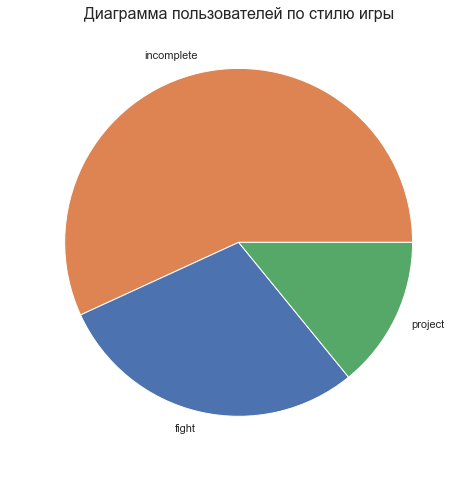

In [70]:
yt_users.groupby('fin_type')['source'].count()\
                                      .sort_values(ascending=False)\
                                      .plot.pie(colors = ['C1','C0','C2'])
plt.title('Диаграмма пользователей по стилю игры', fontsize=16)
plt.xlabel(' ')
plt.ylabel(' ');

Посмотрим, сколько времени проводят в игре пользователи, не завершившие уровень

In [71]:
yt_users.query("fin_type =='incomplete'").describe()

,days_spent,buildings
count,1527.000000,1527.000000
mean,9.075966,8.391618
std,4.379386,4.124839
min,0.000000,1.000000
25%,6.000000,5.000000
50%,9.000000,8.000000
75%,12.000000,12.000000
max,29.000000,20.000000


Количество дней в игре в зависимости от типа завершения уровня

In [72]:
yt_users.groupby('fin_type')['days_spent'].describe()

,count,mean,std,min,25%,50%,75%,max
fin_type,,,,,,,,
fight,780.0,10.600000,4.099720,0.0,8.0,10.0,13.0,27.0
incomplete,1527.0,9.075966,4.379386,0.0,6.0,9.0,12.0,29.0
project,379.0,13.055409,3.379770,6.0,10.0,13.0,15.0,26.0


Количество построенных зданий в зависимости от типа завершения уровня

In [73]:
yt_users.groupby('fin_type')['buildings'].describe()

,count,mean,std,min,25%,50%,75%,max
fin_type,,,,,,,,
fight,780.0,9.474359,3.070102,2.0,8.0,10.0,12.0,18.0
incomplete,1527.0,8.391618,4.124839,1.0,5.0,8.0,12.0,20.0
project,379.0,12.596306,2.197422,10.0,11.0,12.0,14.0,20.0


#### Yandex

In [74]:
yad_users = users.query("source == 'yandex_direct'")

In [75]:
yad_users.sample(10)

,source,first_event,last_event,days_spent,buildings,fin_type
user_id,,,,,,
fa54a606-b43b-4ea5-8955-ab8b8644cc23,yandex_direct,2020-05-04,2020-05-10,5,5,fight
2dbafb75-eb93-40b7-baa1-66406d3a1b2b,yandex_direct,2020-05-04,2020-05-16,11,9,fight
7e3ac94b-4620-4547-95c9-e907b2e2cdca,yandex_direct,2020-05-07,2020-05-21,13,11,incomplete
bbaf225e-5a9a-49e8-ab3c-3f5c1e162e6f,yandex_direct,2020-05-05,2020-05-12,6,13,fight
73e0590f-5f96-4051-9d74-ea45f873e903,yandex_direct,2020-05-04,2020-05-17,13,10,incomplete
5115cdde-578e-493e-b50f-6a049c3f640c,yandex_direct,2020-05-05,2020-05-07,2,2,incomplete
53d8f76d-684f-43c8-a409-33edc00c9930,yandex_direct,2020-05-05,2020-05-11,5,5,fight
9e05ab9d-f6fe-439e-9a42-ade341cb360a,yandex_direct,2020-05-04,2020-05-27,23,16,incomplete
6f284cec-2102-4a60-9695-042bb5216cb4,yandex_direct,2020-05-04,2020-05-19,14,11,fight


Распределение пользователей по проведенным в игре дням

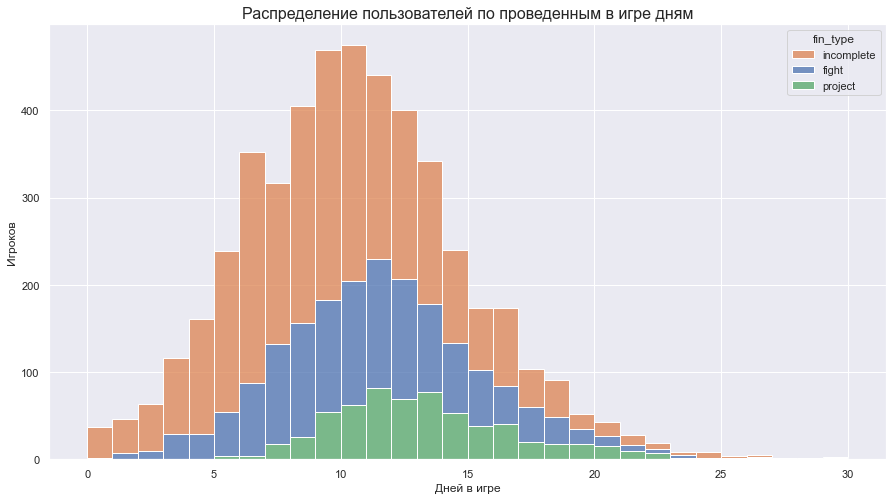

In [76]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(1,1,1)
sns.histplot(data=yad_users, ax=ax, stat="count", multiple="stack",
             x="days_spent", kde=False,
             palette=palette, hue="fin_type",
             element="bars", legend=True, bins=30)
plt.title('Распределение пользователей по проведенным в игре дням', fontsize=16)
plt.xlabel('Дней в игре')
plt.ylabel('Игроков');

Распределение по количеству простроенных объектов

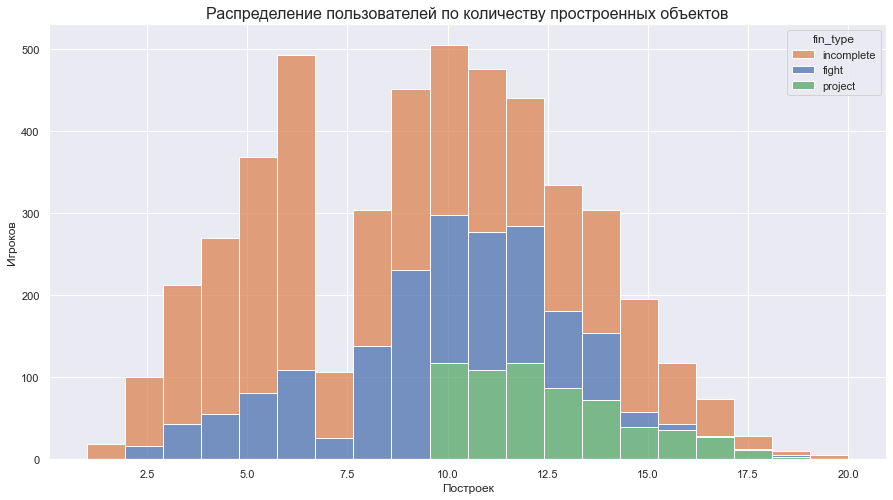

In [77]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(1,1,1)
sns.histplot(data=yad_users, ax=ax, stat="count", multiple="stack",
             x="buildings", kde=False,
             palette=palette, hue="fin_type",
             element="bars", legend=True, bins=20)
plt.title('Распределение пользователей по количеству простроенных объектов', fontsize=16)
plt.xlabel('Построек')
plt.ylabel('Игроков');

Диаграмма рассеяния, показывающая зависимость количества построенных зданий от количества дней, проведенных в игре и от типа завершения уровня.

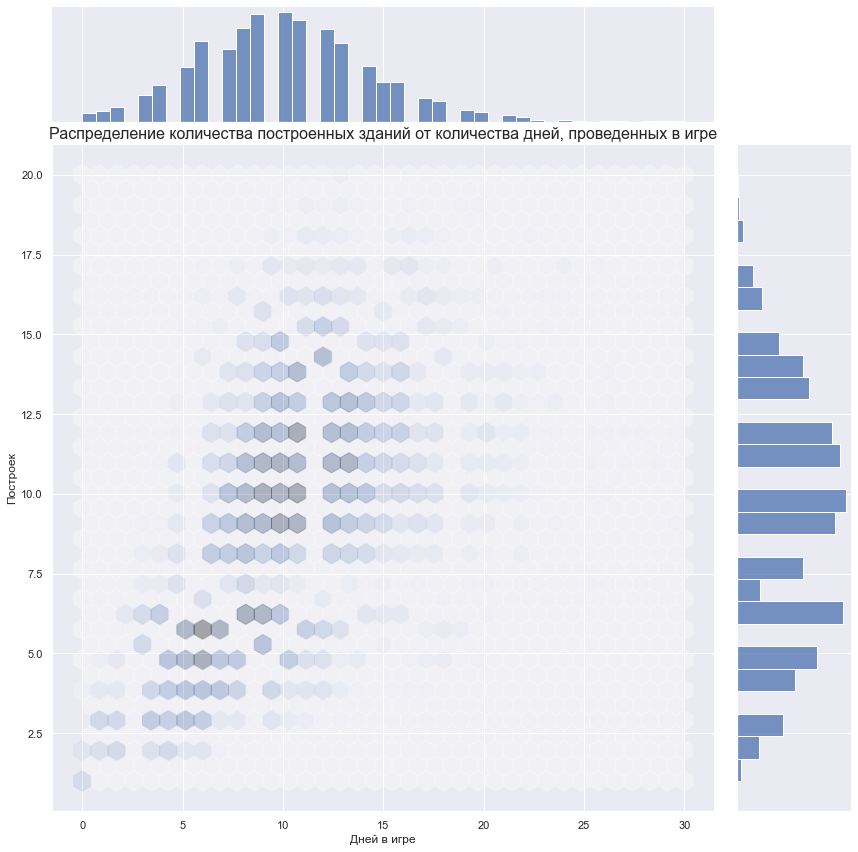

In [78]:
#fb_users.plot.scatter(x='days_spent', y='buildings')
sns.set(rc={'figure.figsize':(15,8)})
palette ={ "fight": "C0","incomplete": "C1", "project": "C2"}
sns.jointplot(data=yad_users, 
                x="days_spent", 
                y="buildings", 
                #hue="fin_type",
                kind='hex',
                palette=palette, 
                height  = 12, alpha=0.3
              )
plt.title('Распределение количества построенных зданий от количества дней, проведенных в игре', fontsize=16)
plt.xlabel('Дней в игре')
plt.ylabel('Построек');

Круговая диаграмма с разбивкой по типам завершения уровня

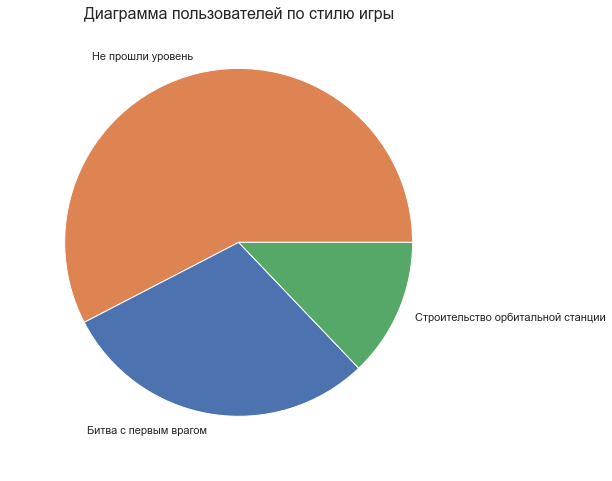

In [79]:
yad_users.groupby('fin_type')['source'].count()\
                                      .sort_values(ascending=False)\
                                      .plot.pie(colors = ['C1','C0','C2'],
                                                labels = ['Не прошли уровень', 'Битва с первым врагом', 'Строительство орбитальной станции'])
plt.title('Диаграмма пользователей по стилю игры', fontsize=16)
plt.xlabel(' ')
plt.ylabel(' ');

Посмотрим, сколько времени проводят в игре пользователи, не завершившие уровень

In [80]:
#сколько времени проводят в игре не завершившие уровень
yad_users.query("fin_type =='incomplete'").describe()

,days_spent,buildings
count,2775.000000,2775.000000
mean,9.243964,8.609369
std,4.311745,4.132823
min,0.000000,1.000000
25%,6.000000,5.000000
50%,9.000000,8.000000
75%,12.000000,12.000000
max,26.000000,20.000000


Количество дней в игре в зависимости от типа завершения уровня

In [81]:
yad_users.groupby('fin_type')['days_spent'].describe()

,count,mean,std,min,25%,50%,75%,max
fin_type,,,,,,,,
fight,1422.0,10.630098,4.137114,0.0,8.0,10.0,13.0,30.0
incomplete,2775.0,9.243964,4.311745,0.0,6.0,9.0,12.0,26.0
project,620.0,12.883871,3.704261,5.0,10.0,12.0,15.0,29.0


Количество построенных зданий в зависимости от типа завершения уровня

In [82]:
yad_users.groupby('fin_type')['buildings'].describe()

,count,mean,std,min,25%,50%,75%,max
fin_type,,,,,,,,
fight,1422.0,9.375527,3.076719,2.0,8.0,10.0,12.0,19.0
incomplete,2775.0,8.609369,4.132823,1.0,5.0,8.0,12.0,20.0
project,620.0,12.595161,2.157523,10.0,11.0,12.0,14.0,19.0


#### Сравнение

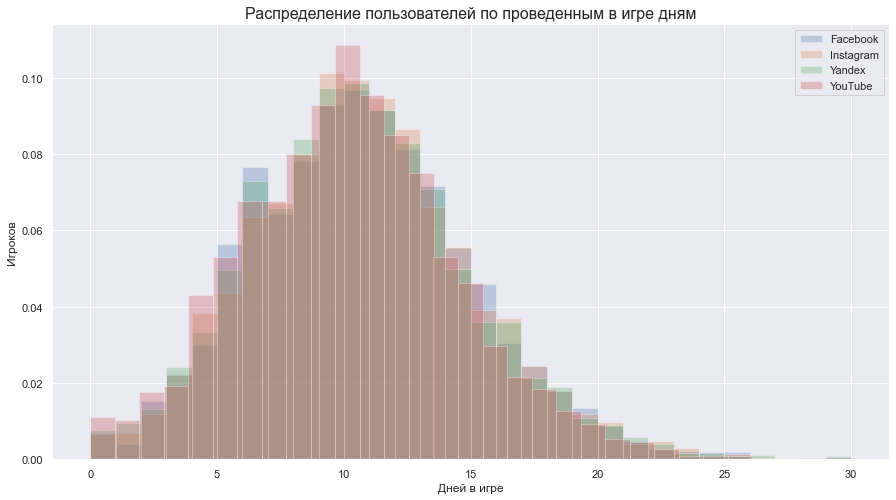

In [83]:
fig, ax = plt.subplots()
ax.hist(fb_users['days_spent'], bins=30, density=True, alpha=0.3)
ax.hist(inst_users['days_spent'], bins=30, density=True, alpha=0.3)
ax.hist(yad_users['days_spent'], bins=30, density=True, alpha=0.3)
ax.hist(yt_users['days_spent'], bins=30, density=True, alpha=0.3)
plt.legend(['Facebook','Instagram','Yandex','YouTube'])
plt.title('Распределение пользователей по проведенным в игре дням', fontsize=16)
plt.xlabel('Дней в игре')
plt.ylabel('Игроков');


#### Завершение уровня

Процент завершивших уровень разными способами

In [84]:
fin_type_source_pivot = users.pivot_table(index='source', columns='fin_type', values='days_spent',aggfunc= 'count')
display(fin_type_source_pivot)

fin_type,fight,incomplete,project
source,,,
facebook_ads,759,1576,391
instagram_new_adverts,990,1881,476
yandex_direct,1422,2775,620
youtube_channel_reklama,780,1527,379


In [85]:
fin_type_source_pivot['total'] = fin_type_source_pivot.sum(axis=1)

In [86]:
fin_type_source_pivot['fight'] = fin_type_source_pivot['fight'] / fin_type_source_pivot['total'] *100
fin_type_source_pivot['incomplete'] = fin_type_source_pivot['incomplete'] / fin_type_source_pivot['total'] *100
fin_type_source_pivot['project'] = fin_type_source_pivot['project'] / fin_type_source_pivot['total'] *100

In [87]:
display(fin_type_source_pivot)

fin_type,fight,incomplete,project,total
source,,,,
facebook_ads,27.842993,57.813646,14.343360,2726
instagram_new_adverts,29.578727,56.199582,14.221691,3347
yandex_direct,29.520448,57.608470,12.871082,4817
youtube_channel_reklama,29.039464,56.850335,14.110201,2686


Процент завершивших уровень

In [88]:
fin_type_source_complete_pivot = users.query("fin_type != 'incomplete'").pivot_table(index='source', columns='fin_type', values='days_spent',aggfunc= 'count')
fin_type_source_complete_pivot['total'] = fin_type_source_complete_pivot.sum(axis=1)
fin_type_source_complete_pivot['fight'] = fin_type_source_complete_pivot['fight'] / fin_type_source_complete_pivot['total'] *100
fin_type_source_complete_pivot['project'] = fin_type_source_complete_pivot['project'] / fin_type_source_complete_pivot['total'] *100
display(fin_type_source_complete_pivot)

fin_type,fight,project,total
source,,,
facebook_ads,66.000000,34.000000,1150
instagram_new_adverts,67.530696,32.469304,1466
yandex_direct,69.637610,30.362390,2042
youtube_channel_reklama,67.299396,32.700604,1159


#### Постройки

Среднее количество построек

In [89]:
build_source_pivot = users.pivot_table(index='source', columns='fin_type', values='buildings',aggfunc= 'mean')
display(build_source_pivot)

fin_type,fight,incomplete,project
source,,,
facebook_ads,9.429513,8.901015,12.649616
instagram_new_adverts,9.400000,8.738437,12.756303
yandex_direct,9.375527,8.609369,12.595161
youtube_channel_reklama,9.474359,8.391618,12.596306


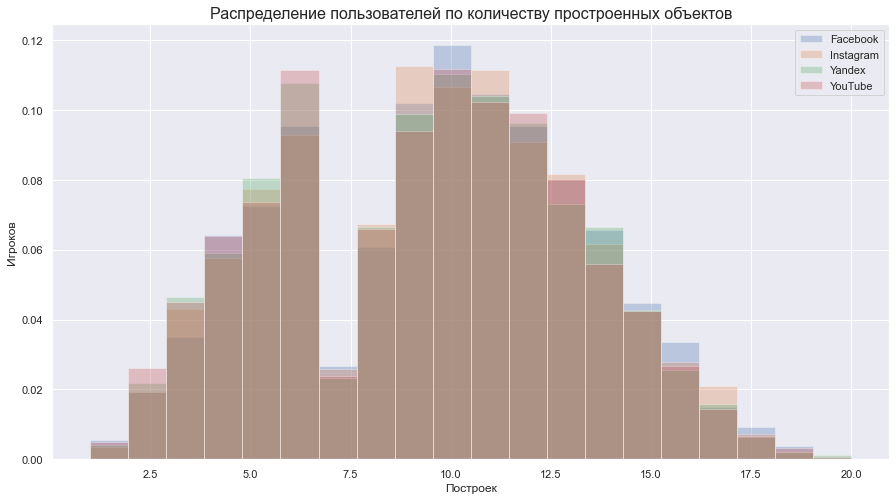

In [90]:
fig, ax = plt.subplots()
ax.hist(fb_users['buildings'], bins=20, density=True, alpha=0.3)
ax.hist(inst_users['buildings'], bins=20, density=True, alpha=0.3)
ax.hist(yad_users['buildings'], bins=20, density=True, alpha=0.3)
ax.hist(yt_users['buildings'], bins=20, density=True, alpha=0.3)

plt.legend(['Facebook','Instagram','Yandex','YouTube'])
plt.title('Распределение пользователей по количеству простроенных объектов', fontsize=16)
plt.xlabel('Построек')
plt.ylabel('Игроков');

#### Вывод

- Сильных различий в поведении пользователей, пришедших из разных источников, не наблюдается.
- Распределение пользователей по проведенным в игре дням близко к нормальному, с небольшим смещением влево. Среднее и медиана близки. 
- Игроки, предпочитающие прохождение уровня через босса, проводят на первом уровне меньше дней, чем игроки, выбирающие реализацию проекта.
- Аналогичная ситуация по постройкам.
- Из графиков 'Распределение пользователей по количеству простроенных объектов' видно, что пользователям, выбирающим реализацию проекта, необходимо построить не менее 10 зданий.
- На графиках также заметен провал на месте 7 зданий. Из данных неизвестно, что в игровом дизайне может на это влиять.
- На графиках отношения количества простроек и дней в игре видна положительная зависимость, но правилом ее назвать нельзя.
- Диаграммы пользователей по стилю игры показывает преобладание игроков, незавершивших первый уровень.    
   
      
- Около 57% игроков не завершиют первый уровень.
- Из завершивших первый уровень около 67% выбирают победу над первым врагом.

<div style="background:#d4d6fa; color:#000; padding:10px; margin-top:10px">
    <p><b> Комментарий тимлида: </b></p>
    
Вот это всё хочется видеть в форме промежуточных выводов. Так как выше ты дал огромное количество графиков и прочей информации и удержать её всю в голове практически невозможно. В итоге чтобы убедиться в выводах нужно много листать вверх-вниз, искать то место, по которому ты сделал вывод и т.д. 
    
Всё это сильно усложняет восприятие проекта.
</div>

### По вовлеченности

#### Потратившие наибольшее время в игре (длительность в мин и днях, удержание)

Средняя скорость завершения уровня

In [91]:
av_days_pivot = users.pivot_table(index='source', columns='fin_type', values='days_spent',aggfunc= 'mean')
display(av_days_pivot)

fin_type,fight,incomplete,project
source,,,
facebook_ads,10.546772,9.402284,12.905371
instagram_new_adverts,10.622222,9.418926,13.039916
yandex_direct,10.630098,9.243964,12.883871
youtube_channel_reklama,10.600000,9.075966,13.055409


In [92]:
av_days_pivot = users.pivot_table(index='source', columns='fin_type', values='days_spent',aggfunc= 'median')
display(av_days_pivot)

fin_type,fight,incomplete,project
source,,,
facebook_ads,10,9,12
instagram_new_adverts,10,9,13
yandex_direct,10,9,12
youtube_channel_reklama,10,9,13


#### Не прошедшие первый уровень и забросившие игру

In [93]:
churn_users = users.query("fin_type == 'incomplete'")
display(churn_users.sample(5))

,source,first_event,last_event,days_spent,buildings,fin_type
user_id,,,,,,
bed3c16f-00b5-4953-9ece-9ba19a1099a4,yandex_direct,2020-05-07,2020-05-24,17,9,incomplete
971a7d7b-c9f0-42b6-985b-fd7344df4eca,facebook_ads,2020-05-04,2020-05-10,6,2,incomplete
ad5cf28c-4a31-4bef-ac57-5251d64ec7a5,youtube_channel_reklama,2020-05-04,2020-05-15,11,7,incomplete
53e239cd-1a0e-4918-af2b-557335f2ead4,instagram_new_adverts,2020-05-04,2020-05-15,10,6,incomplete
a053ce24-e72b-4147-bd39-15f22169a6e1,facebook_ads,2020-05-04,2020-05-16,11,9,incomplete


In [94]:
retained_users = users.query("fin_type != 'incomplete'")

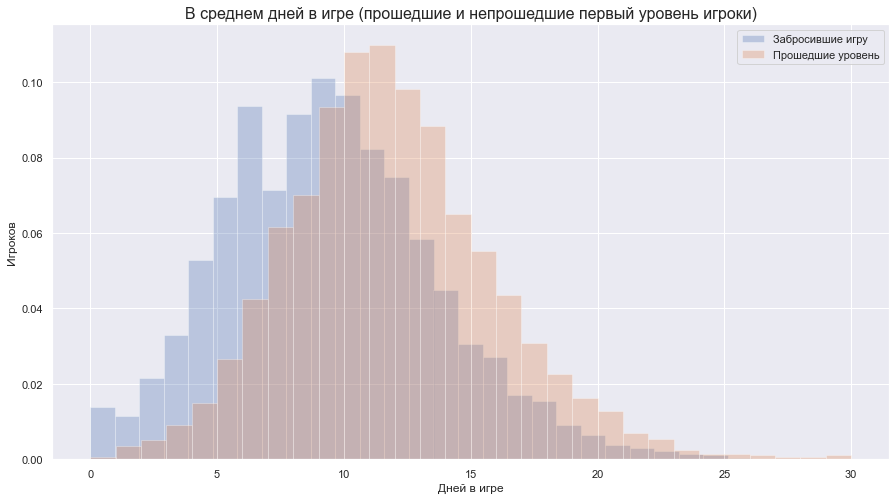

In [95]:
fig, ax = plt.subplots()
ax.hist(churn_users['days_spent'], bins=30, density=True, alpha=0.3)
ax.hist(retained_users['days_spent'], bins=30, density=True, alpha=0.3)

plt.legend(['Забросившие игру','Прошедшие уровень'])
plt.title('В среднем дней в игре (прошедшие и непрошедшие первый уровень игроки)', fontsize=16)
plt.xlabel('Дней в игре')
plt.ylabel('Игроков');

#### Вывод

* Игроки, не прошедшие первый уровень, в среднем проводят в игре меньше дней, чем остальные игроки.
* В среднем игроки завершают первый уровень за 10-12 дней. 
* Незавершившие первый уровень игроки провели в игре в среднем 9 дней.

## Анализ источников трафика

### Динамика установок

Количество привлеченных пользователей по датам, с разбивкой по источникам

In [96]:
users_source_by_date = users.pivot_table(index='first_event', columns='source', values='days_spent', aggfunc='count')
display(users_source_by_date)

source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama
first_event,,,,
2020-05-04,1184,1452,2078,1146
2020-05-05,694,796,1208,663
2020-05-06,345,472,664,366
2020-05-07,224,270,395,220
2020-05-08,139,175,239,135
2020-05-09,84,112,144,100
2020-05-10,56,70,89,56


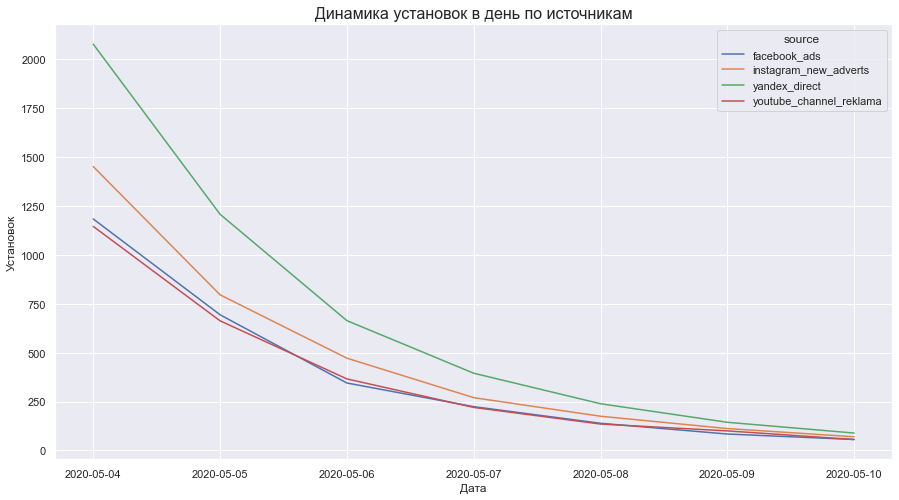

In [97]:
users_source_by_date.plot()
plt.title('Динамика установок в день по источникам', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Установок');

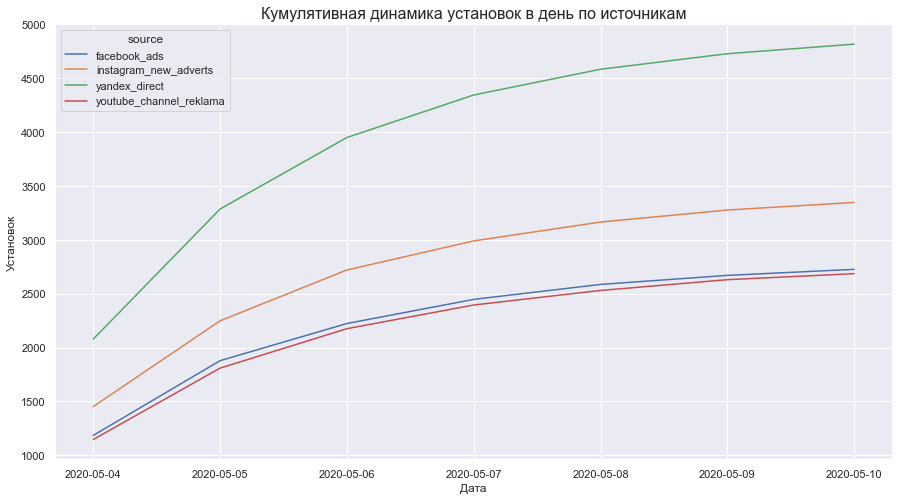

In [98]:
users_source_by_date_cum = users_source_by_date.cumsum()
users_source_by_date_cum.plot()
plt.title('Кумулятивная динамика установок в день по источникам', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Установок');

### Динамика трат

Посчитаем суммарные траты на привлечение пользователей

In [99]:
ad_cos_by_day_source = ad_costs.pivot_table(index='day',values='cost',columns='source', aggfunc='sum')
display(ad_cos_by_day_source)

source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama
day,,,,
2020-05-03,935.882786,943.204717,969.139394,454.224943
2020-05-04,548.354480,502.925451,554.651494,259.073224
2020-05-05,260.185754,313.970984,308.232990,147.041741
2020-05-06,177.982200,173.071145,180.917099,88.506074
2020-05-07,111.766796,109.915254,114.429338,55.740645
2020-05-08,68.009276,71.578739,62.961630,40.217907
2020-05-09,38.723350,46.775400,42.779505,23.314669


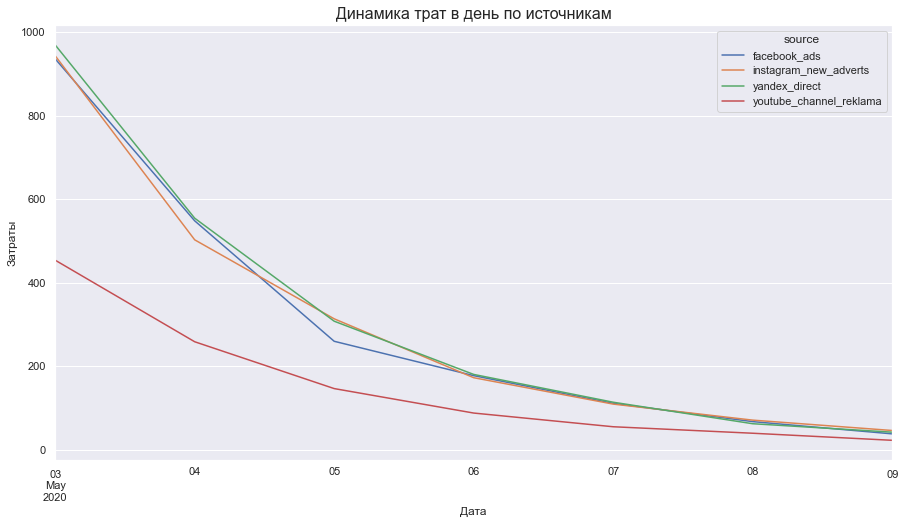

In [100]:
ad_cos_by_day_source.plot()
plt.title('Динамика трат в день по источникам', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Затраты');

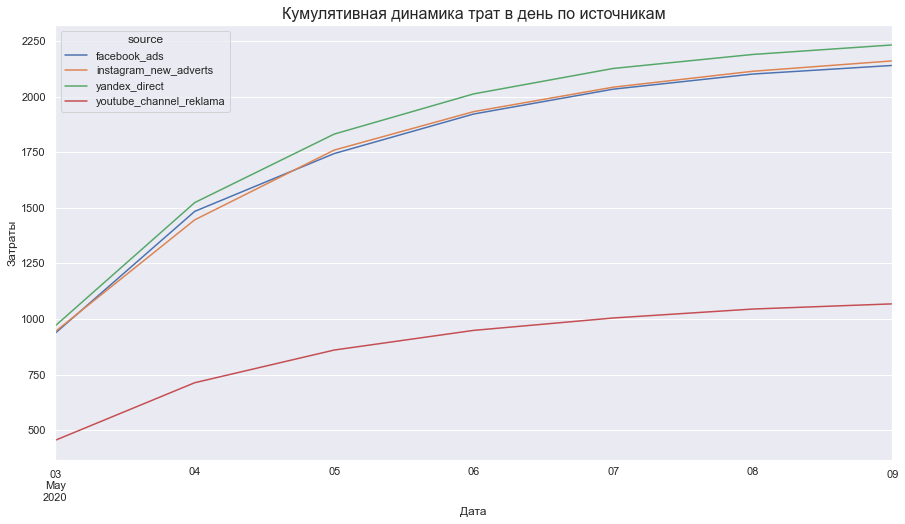

In [101]:
ad_cos_by_day_source_cum = ad_cos_by_day_source.cumsum()
ad_cos_by_day_source_cum.plot()
plt.title('Кумулятивная динамика трат в день по источникам', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Затраты');

Посчитаем средние траты на 1 установку по дням

In [102]:
users_source_by_date = users.pivot_table(index='first_event', columns='source', values='days_spent', aggfunc='count')
users_source_by_date.index = users_source_by_date.index - pd.Timedelta(days=1)
user_cost_per_day = ad_cos_by_day_source / users_source_by_date
display(user_cost_per_day)

source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama
day,,,,
2020-05-03,0.790442,0.649590,0.466381,0.396357
2020-05-04,0.790136,0.631816,0.459149,0.390759
2020-05-05,0.754162,0.665193,0.464206,0.401753
2020-05-06,0.794563,0.641004,0.458018,0.402300
2020-05-07,0.804078,0.628087,0.478784,0.412894
2020-05-08,0.809634,0.639096,0.437234,0.402179
2020-05-09,0.691488,0.668220,0.480669,0.416333


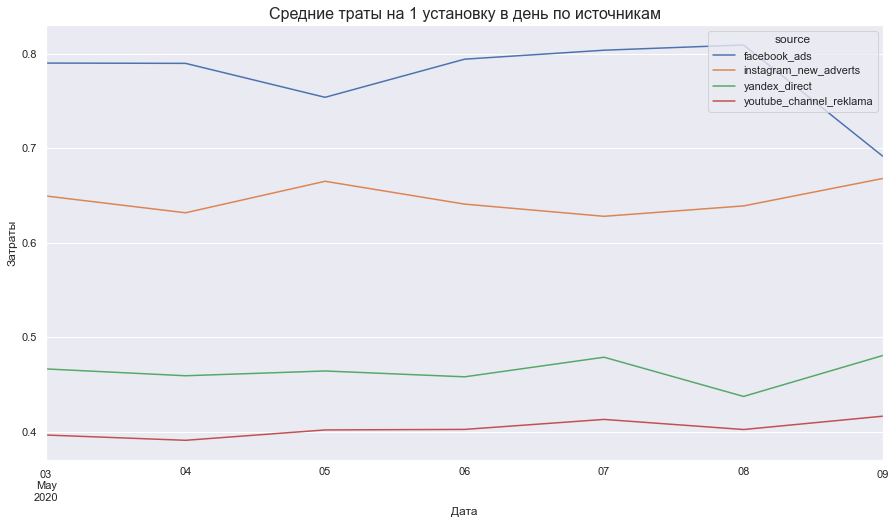

In [103]:
user_cost_per_day.plot()
plt.title('Средние траты на 1 установку в день по источникам', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Затраты');

In [104]:
display(user_cost_per_day.mean())

source
facebook_ads               0.776358
instagram_new_adverts      0.646144
yandex_direct              0.463491
youtube_channel_reklama    0.403225
dtype: float64

### Динамика завершения уровня

Посчитаем пороцент завершивших первый уровень пользователей по датам привлечения и источникам 

In [105]:
users_compl_incomp = users.copy()
#users_compl_incomp.query("fin_type !=incomplete ")['fin_type'] = 'complete'
users_compl_incomp['fin_type'] = users_compl_incomp['fin_type'].replace('fight',1)
users_compl_incomp['fin_type'] = users_compl_incomp['fin_type'].replace('project',1)
users_compl_incomp['fin_type'] = users_compl_incomp['fin_type'].replace('incomplete',0)

In [106]:
complete_rate_by_source = users_compl_incomp.pivot_table(index='first_event',
                                                         columns='source',
                                                         values='fin_type',
                                                         aggfunc='mean')
display(complete_rate_by_source)

source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama
first_event,,,,
2020-05-04,0.448480,0.467631,0.441290,0.473822
2020-05-05,0.449568,0.464824,0.440397,0.450980
2020-05-06,0.391304,0.419492,0.433735,0.409836
2020-05-07,0.339286,0.388889,0.379747,0.368182
2020-05-08,0.359712,0.348571,0.355649,0.288889
2020-05-09,0.380952,0.258929,0.284722,0.320000
2020-05-10,0.250000,0.342857,0.325843,0.267857


Нанесем данные на график

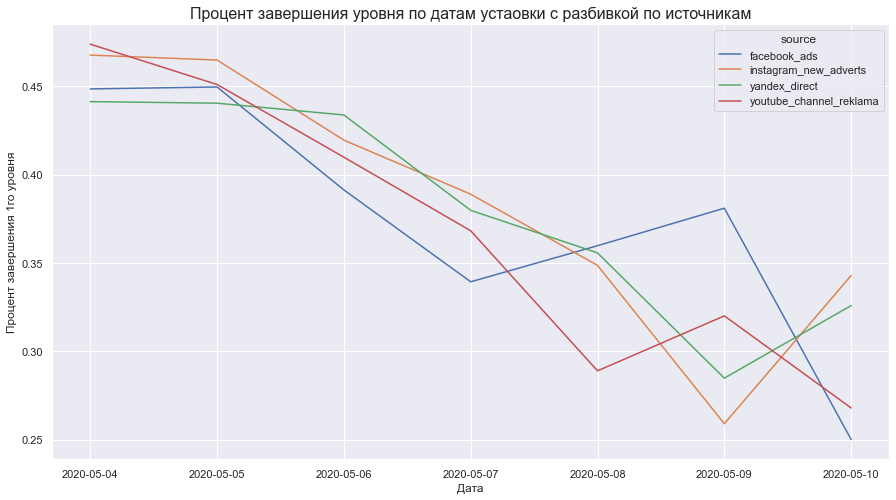

In [107]:
complete_rate_by_source.plot()
plt.title('Процент завершения уровня по датам устаовки с разбивкой по источникам', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Процент завершения 1го уровня');

под конец кампании мало установок и поэтому большой разброс

### Вывод

* К концу рекламной кампании количество привлеченных пользователей значительно ниже, чем на старте.
* Больше всего пользователей пришло через рекламу в Yandex Direct.
* На втором месте по привлечению пользователей — Instagram
* Из YouTube и Facebook приходит одинаковое количество пользователей.
* Дешевле всего обходятся пользователи, пришедшие через YouTube. 
* У остальных рекламных источников стоимость привлечения одного пользователя примерно одинаковая, с небольшим отклонением в большую сторону у Yandex Direct 
* Средняя стоимость 1 установки по каждому источнику с течением рекламной кампании меняется не сильно и составляет:
    * Facebook — 0.78 у.е.
    * Instagram — 0.65 у.е.
    * Yandex Direct  — 0.46 у.е.
    * YouTube — 0.4 у.е.
* Процент завершения первого уровня не сильно зависит от источника привлечения пользователя.
* Под конец анализируемого периода количество привлеченных пользователей очень мало, что приводит к сильному разбросу.


## Проверка гипотез

### Гипотеза 1

$H_0$: Среднее время завершения уровня при разных способах прохождения не имеет существенных различий    

$H_1$: Среднее время завершения уровня различается при разных способах прохождения игры

<div class="alert alert-info"> <b>Комментарии студентки:</b> Исправила </div>

<div class="alert alert-warning">
    <p><b>Комментарий тимлида: </b></p>
    
**Среднее** время завершения...
    
Так как ниже ты используешь t-тест, а он проверяет гипотезу о равенстве средних значений (оценок мат. ожидания). Стат. гипотезы должны быть согласованы с используемым критерием. Так, например, при использовании z-теста, гипотезы были бы уже о долях и т.д.
</div>

<div class="alert alert-success">
    <p><b>Комментарий тимлида v2: </b>Теперь согласуется и тут, и ниже</p>
</div>

In [108]:
sample_A = users.query("fin_type == 'fight'")['days_spent'].copy()
sample_B = users.query("fin_type == 'project'")['days_spent'].copy()

In [109]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    sample_A, 
    sample_B)
print('Type "fight" mean:', sample_A.mean())
print('Type "project" mean:', sample_B.mean(),'\n')
print('Fight to project difference', (sample_A.mean()/sample_B.mean()-1)*100,'\n')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Type "fight" mean: 10.606175651733738
Type "project" mean: 12.963022508038586 

Fight to project difference -18.181306518933592 

p-значение: 1.8882835392369192e-97
Отвергаем нулевую гипотезу


#### Вывод

* Разница во времени прохождения уровня в зависимости от стиля игры составляет 18%. Игроки, выбирающие реализацию проекта, тратят в игре больше времени — около 13 дней, против 10 дней при выборе схватки с первым врагом.
* Вероятность совершить ошибку при отвержении данной гипотезы близка к нулю. 

<div class="alert alert-info"> <b>Комментарии студентки:</b> Добавила комментарий </div>

<div style="background:#d4d6fa; color:#000; padding:10px; margin-top:10px">
    <p><b> Комментарий тимлида: </b></p>
    
А кто в итоге тратит больше? Аналогично и в остальных гипотезах, если мы обнаруживаем наличие разницы, то хочется знать в чью пользу эта разница.
</div>

### Гипотеза 2

$H_0$: Игроки, прошедшие первый уровень, и игроки, неокончившие его, в среднем провели в игре одинаковое количество дней

$H_1$: Игроки, прошедшие первый уровень, и игроки, неокончившие его, в среднем провели в игре разное количество дней

In [110]:
sample_A2 = users.query("fin_type == 'fight' or fin_type == 'project'")['days_spent'].copy()
sample_B2 = users.query("fin_type == 'incomplete'")['days_spent'].copy()

In [111]:
alpha = .01 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    sample_A2, 
    sample_B2)
print('Type "complete" mean:', sample_A2.mean())
print('Type "incomplete" mean:', sample_B2.mean(),'\n')
print('difference', (sample_A2.mean()/sample_B2.mean()-1)*100,'\n')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Type "complete" mean: 11.362214199759325
Type "incomplete" mean: 9.28547493233664 

difference 22.36546092209506 

p-значение: 5.1444050916040245e-171
Отвергаем нулевую гипотезу


#### Вывод

* Разница во времени, проведенном в игре пользователями, завершившими уровень и не завершившими его, составляет 22.4% — незавершившие первый уровень игроки проводят в игре около 9 дней, против 12 у прошедших первый уровень.
* Вероятность совершить ошибку при отвержении данной гипотезы близка к нулю. 

### Гипотеза 3

$H_0$: Игроки, пришедшие из разных истоников, завершают первый уровень с одинаковой вероятностью

$H_1$: Игроки, пришедшие из разных истоников, завершают первый уровень с разной вероятностью

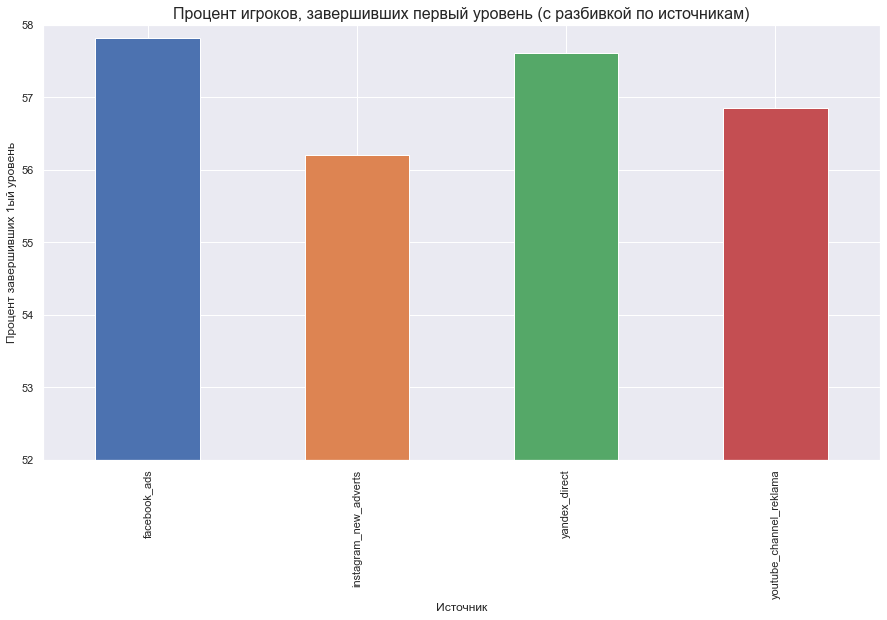

In [112]:
incomplete_source = users_compl_incomp.pivot_table(index='source',columns='fin_type',values='days_spent',aggfunc='count')
incomplete_source[1] = incomplete_source[0]+incomplete_source[1]
incomplete_source = incomplete_source.rename(columns = {1:'total', 0:'incomplete'})
incomplete_source = (incomplete_source['incomplete']/incomplete_source['total'])*100

incomplete_source.plot(kind='bar', ylim=[52,58],color=['C0','C1','C2','C3'])
plt.title('Процент игроков, завершивших первый уровень (с разбивкой по источникам)', fontsize=16)
plt.xlabel('Источник')
plt.ylabel('Процент завершивших 1ый уровень');

In [113]:
def groups_difference (group_1, group_2, alpha):
    
    leads = [group_1.count(),group_2.count()]
    purchases = [group_1.sum(),group_2.sum()]    
    
    
    p1 = purchases[0]/leads[0]  # пропорция успехов в первой группе

    p2 = purchases[1]/leads[1] # пропорция успехов во второй группе

    p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1]) # пропорция успехов в комбинированном датасете

    difference = p1 - p2  # разница пропорций в датасетах

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))

    distr = st.norm(0, 1) #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)

    p_value = p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('Первая группа: %.3f' % p1,' Вторая группа: %.3f' % p2,' Разница: %.3f' % -difference)
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными'
        )     
        
        

In [114]:
sample_Fb = users_compl_incomp.query(" source == 'facebook_ads'")['fin_type'].copy()
sample_In = users_compl_incomp.query(" source == 'instagram_new_adverts'")['fin_type'].copy()
sample_Ya = users_compl_incomp.query(" source == 'yandex_direct'")['fin_type'].copy()
sample_Yt = users_compl_incomp.query(" source == 'youtube_channel_reklama'")['fin_type'].copy()

Так как сравниваемых групп 4, то, чтобы провести все возможные сравнения, нужно применить поправку Бонферрони, уменьшив необходимый уровень значимости в 6 раза.

In [115]:
print('Fb / Inst')
groups_difference(sample_Fb, sample_In, 0.05/6)
print('\n')

print('Fb / Ya')
groups_difference(sample_Fb, sample_Ya, 0.05/6)
print('\n')

print('Fb / Yt')
groups_difference(sample_Fb, sample_Yt, 0.05/6)
print('\n')

print('Ins / Ya')
groups_difference(sample_In, sample_Ya, 0.05/6)
print('\n')

print('Ins / Yt')
groups_difference(sample_In, sample_Yt, 0.05/6)
print('\n')

print('Yt / Ya')
groups_difference(sample_Yt, sample_Ya, 0.05/6)
print('\n')
    

Fb / Inst
Первая группа: 0.422  Вторая группа: 0.438  Разница: 0.016
p-значение:  0.20644137086490777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


Fb / Ya
Первая группа: 0.422  Вторая группа: 0.424  Разница: 0.002
p-значение:  0.8624388026512437
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


Fb / Yt
Первая группа: 0.422  Вторая группа: 0.431  Разница: 0.010
p-значение:  0.4737412931629539
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


Ins / Ya
Первая группа: 0.438  Вторая группа: 0.424  Разница: -0.014
p-значение:  0.20595754565724533
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


Ins / Yt
Первая группа: 0.438  Вторая группа: 0.431  Разница: -0.007
p-значение:  0.6123664865502236
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


Yt / Ya
Первая группа: 0.431  Вторая группа: 0.424  Разница: -0.008
p-значение:  0.5244

#### Вывод

* В разделе анализа динамики завершения первого уровня мы определили, что разница между игроками, пришедшими из разных источников, отсутствует. Провека данной гипотезы это подтвердила.
* Разница в скорости прохождения первого уровня у игроков из разных источников составляет меньше процента.

## Общий вывод

* В ходе подготовки к анализу были выполнены следующие шаги:
    * Проведен предварительный обзор полученных данных.
    * Удалены дубликаты событий.
    * Создана и заполнена сводными данными таблица пользователей.    
    
    
         
* В рамках предварительного анализа было выделено следующее:
    * Период проведения рекламной кампании: 03 - 09 Мая 2020г.
    * Привлечено уникальных пользователей — 13576.
    * Источники привлечения пользователей:
        * Facebook ads
        * Yandex Direct
        * YouTube Channel
        * Instagram Adverts
    * Период первых игровый сессий: 04 - 10 Мая 2020г.
    * Период игровой активности пользователей: 04 Мая - 05 Июня 2020г.
  
   
* Анализ поведения пользователей показал:    
    * Различий в поведении пользователей, пришедших из разных источников, не выявлено.
    * Игроки, предпочитающие прохождение уровня через босса, проводят на первом уровне меньше дней, чем игроки, выбирающие реализацию проекта. Разница во времени прохождения уровня составляет 18%
    * Около 57% игроков не завершиют первый уровень.
    * Из завершивших первый уровень около 67% выбирают победу над первым врагом.
    * Пользователи, проходящие первый уровень через реализацию проекта, строят не меньше 10 зданий.
    * Так же заметна просадка в пользователях, построивших 7 зданий. Возможно, это обусловлено игровой механикой. Стоит сообщить об этом отделу гейм-дизайна.
    * Игроки, не прошедшие первый уровень, в среднем проводят в игре меньше дней, чем остальные игроки.
    * В среднем игроки завершают первый уровень за 10-12 дней.
    * Незавершившие первый уровень игроки провели в игре в среднем 9 дней.    
    * Разница во времени, проведенном в игре пользователями, завершившими уровень и не завершившими его, составляет 22.4%
    * Разница в скорости прохождения первого уровня у игроков, пришедших из разных источников, составляет меньше процента.
    
    
* Анализ результатов рекламной кампании показал:
    * Больше всего пользователей пришло через рекламу в Yandex Direct.
    * На втором месте по привлечению пользователей — Instagram
    * Из YouTube и Facebook приходит одинаковое количество пользователей
    * Дешевле всего обходятся пользователи, пришедшие через YouTube.
    * У остальных рекламных источников стоимость привлечения одного пользователя примерно одинаковая, с небольшим отклонением в большую сторону у Yandex Direct
    * Средняя стоимость 1 установки по каждому источнику с течением рекламной кампании меняется не сильно и составляет:
        * Facebook — 0.78 у.е.
        * Instagram — 0.65 у.е.
        * Yandex Direct — 0.46 у.е.
        * YouTube — 0.4 у.е.
    * Процент завершения первого уровня не сильно зависит от источника привлечения пользователя.
    * Под конец анализируемого периода количество привлеченных пользователей значительно ниже, чем на старте.
       
       
       
**Рекомендации**        
* Так как на рекламу в Facebook, Instagram и Yandex Direct было вложено одинаковое количество средств, но через последний пришло больше пользователей, это снизило среднюю стоимость привлечения одного игрока через Yandex Direct (0.46у.е против 0.65 у Instagram и 0.78 у Facebook). При этом поведение пользователей из разных источников не имеет значимых различий. В связи с чем имеет смысл сосредоточиться на рекламе именно через Yandex Direct.
* Так же стоит обратить внимание отдела разработки и гейм-дизайна на просадку количества пользователей, построивших 7 зданий в игре. 
* В свзи с тем, что около 57% пользователей не проходят первый уровень, стоит обсудить с отделом гейм-дизайна возможность доработки процесса обучения новых игроков или изменения сложности первого уровня.

<div class="alert alert-danger">
    <p><b>Комментарий тимлида: </b></p>
    
Я вижу огромное количество фактов, но я не вижу ответа на главный вопрос заказчика - ранжирование каналов.
</div>

<div class="alert alert-info"> <b>Комментарии студентки:</b> Добавила рекомендации </div>

<div class="alert alert-success">
    <p><b>Комментарий тимлида v2: </b>👍</p>
    
</div>

In [116]:
pd.to_csv(users, 'users.csv')

AttributeError: module 'pandas' has no attribute 'to_csv'